# 🌾 Sistema IoT - Classificação de Grãos com Detecção de Anomalia
## Análise Completa + Modelo de Produção
## Criado por Uender Carlos Barbosa - Email: u.carlos3@gmail.com

**Características:**
- ❌ **Banda 485nm REMOVIDA** (CV%>100%, problemas de qualidade)
- ✅ **17 bandas espectrais** (410-940nm exceto 485nm)
- ✅ **Estatísticas completas**: PERMANOVA, Betadisper, ANOVA, Tukey, ICC, CV%, SNR
- ✅ **Validação LOSO** (Leave-One-Sample-Out)
- ✅ **Detecção de Anomalia**: One-Class SVM + MAD por espécie
- ✅ **Modelo único PKL** pronto para Flask (compatível com ESP32)

---

## 1. Importações

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score, balanced_accuracy_score
)
from sklearn.model_selection import LeaveOneGroupOut
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import joblib
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

print("✅ Bibliotecas carregadas")
print(f"   NumPy: {np.__version__}")
print(f"   Pandas: {pd.__version__}")

✅ Bibliotecas carregadas
   NumPy: 2.0.2
   Pandas: 2.2.2


## 2. Carregamento dos Dados

In [2]:
from google.colab import files

print("📤 Faça upload do arquivo CSV")
print("Formato: sample,grain,repetition,band_410,...,band_940")
uploaded = files.upload()

filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

print(f"\n✅ Arquivo: {filename}")
print(f"   Dimensões: {df.shape[0]} linhas × {df.shape[1]} colunas")
print(f"\n📊 Primeiras 3 linhas:")
display(df.head(3))

📤 Faça upload do arquivo CSV
Formato: sample,grain,repetition,band_410,...,band_940


Saving tabela_coleta_dados_espectrais_4_amostras.csv to tabela_coleta_dados_espectrais_4_amostras.csv

✅ Arquivo: tabela_coleta_dados_espectrais_4_amostras.csv
   Dimensões: 48 linhas × 21 colunas

📊 Primeiras 3 linhas:


sample grain  repetition  band_410  band_435  band_460  band_485  band_510  \
0       1  soja           1  0.329470  0.181629  0.236831  0.747495  0.353891   
1       1  soja           2  0.336093  0.184224  0.237852  0.000000  0.358030   
2       1  soja           3  0.336093  0.184224  0.238873  0.000000  0.364238   

   band_535  band_560  ...  band_610  band_645  band_680  band_705  band_730  \
0  0.430511  0.363830  ...  0.520243  0.466258  0.600000  0.554455  0.657371   
1  0.428725  0.372340  ...  0.532389  0.472393  0.586486  0.564356  0.677291   
2  0.439443  0.391489  ...  0.548583  0.503067  0.600000  0.564356  0.677291   

   band_760  band_810  band_860  band_900  band_940  
0  0.639535      0.55  0.591912  0.675676  0.730769  
1  0.639535      0.56  0.588235  0.702703  0.730769  
2  0.668605      0.56  0.613971  0.702703  0.730769  

[3 rows x 21 columns]

## 3. Preparação: Remoção Banda 485nm

In [3]:
print("\n🔧 PREPARAÇÃO DOS DADOS")
print("="*70)

# Identificar bandas originais
band_cols_original = [col for col in df.columns if col.startswith('band_')]
print(f"\n📡 Bandas originais: {len(band_cols_original)}")
print(f"   {', '.join([c.replace('band_', '') + 'nm' for c in band_cols_original])}")

# REMOVER BANDA 485nm
if 'band_485' in df.columns:
    df = df.drop('band_485', axis=1)
    print(f"\n❌ Banda 485nm REMOVIDA")
    print(f"   Motivo: CV%>100%, SNR<1, ~42% valores zerados")

# Nova lista de bandas
band_cols = [col for col in df.columns if col.startswith('band_')]
print(f"\n✅ Bandas mantidas: {len(band_cols)}")
print(f"   {', '.join([c.replace('band_', '') + 'nm' for c in band_cols])}")

# Criar lista de nomes R (para compatibilidade)
bandas_r = ['r' + col.replace('band_', '') for col in band_cols]
df_bandas = df[band_cols].copy()
df_bandas.columns = bandas_r

# Adicionar colunas categóricas
df_bandas['sample'] = df['sample'].astype('category')
df_bandas['grain'] = df['grain'].astype('category')
df_bandas['repetition'] = df['repetition'].astype('category')

print(f"\n🌾 Grãos: {df_bandas['grain'].unique().tolist()}")
print(f"📦 Amostras por grão: {df_bandas.groupby('grain')['sample'].nunique().to_dict()}")
print(f"📊 Total de medições: {len(df_bandas)}")


🔧 PREPARAÇÃO DOS DADOS

📡 Bandas originais: 18
   410nm, 435nm, 460nm, 485nm, 510nm, 535nm, 560nm, 585nm, 610nm, 645nm, 680nm, 705nm, 730nm, 760nm, 810nm, 860nm, 900nm, 940nm

❌ Banda 485nm REMOVIDA
   Motivo: CV%>100%, SNR<1, ~42% valores zerados

✅ Bandas mantidas: 17
   410nm, 435nm, 460nm, 510nm, 535nm, 560nm, 585nm, 610nm, 645nm, 680nm, 705nm, 730nm, 760nm, 810nm, 860nm, 900nm, 940nm

🌾 Grãos: ['soja', 'grao_de_bico', 'milheto', 'sorgo']
📦 Amostras por grão: {'grao_de_bico': 4, 'milheto': 4, 'soja': 4, 'sorgo': 4}
📊 Total de medições: 48


## 4. Matriz de Dados Espectrais

In [4]:
# Extrair matriz de bandas
X_raw = df_bandas[bandas_r].values

# Padronizar
scaler_bandas = StandardScaler()
X_scaled = scaler_bandas.fit_transform(X_raw)

print("\n📐 MATRIZES ESPECTRAIS")
print("="*70)
print(f"X_raw shape: {X_raw.shape}")
print(f"X_scaled shape: {X_scaled.shape}")
print(f"\nEstatísticas X_raw:")
print(f"  Média: {X_raw.mean():.4f}")
print(f"  Std: {X_raw.std():.4f}")

# Dados agregados por amostra (para análises robustas)
df_avg = df_bandas.groupby(['grain', 'sample'])[bandas_r].mean().reset_index()
X_avg = df_avg[bandas_r].values
X_avg_scaled = scaler_bandas.transform(X_avg)

print(f"\n📊 Dados agregados (média por amostra):")
print(f"  df_avg shape: {df_avg.shape}")
print(f"  Amostras por grão: {df_avg.groupby('grain').size().to_dict()}")


📐 MATRIZES ESPECTRAIS
X_raw shape: (48, 17)
X_scaled shape: (48, 17)

Estatísticas X_raw:
  Média: 0.4496
  Std: 0.1624

📊 Dados agregados (média por amostra):
  df_avg shape: (16, 19)
  Amostras por grão: {'grao_de_bico': 4, 'milheto': 4, 'soja': 4, 'sorgo': 4}


## 5. PCA - Análise de Componentes Principais

In [5]:
print("\n📊 PCA")
print("="*70)

pca = PCA(n_components=len(bandas_r))
X_pca = pca.fit_transform(X_scaled)

var_exp = pca.explained_variance_ratio_
var_cum = np.cumsum(var_exp)

df_pca_var = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(len(var_exp))],
    'Variancia_%': var_exp * 100,
    'Variancia_Acum_%': var_cum * 100
})

print("\nVariância explicada (10 primeiros PCs):")
display(df_pca_var.head(10))

print(f"\n📈 RESUMO:")
print(f"  PC1: {var_exp[0]*100:.2f}%")
print(f"  PC1+PC2: {var_cum[1]*100:.2f}%")
print(f"  6 PCs: {var_cum[5]*100:.2f}%")

df_pca_var.to_csv('pca_variancia.csv', index=False)
print("\n✅ Salvo: pca_variancia.csv")


📊 PCA

Variância explicada (10 primeiros PCs):


PC  Variancia_%  Variancia_Acum_%
0   PC1    87.339608         87.339608
1   PC2     6.525624         93.865232
2   PC3     3.567943         97.433175
3   PC4     0.909588         98.342763
4   PC5     0.642243         98.985006
5   PC6     0.368720         99.353726
6   PC7     0.187759         99.541485
7   PC8     0.178904         99.720389
8   PC9     0.091299         99.811688
9  PC10     0.057867         99.869555


📈 RESUMO:
  PC1: 87.34%
  PC1+PC2: 93.87%
  6 PCs: 99.35%

✅ Salvo: pca_variancia.csv


## 6. Gráfico PCA

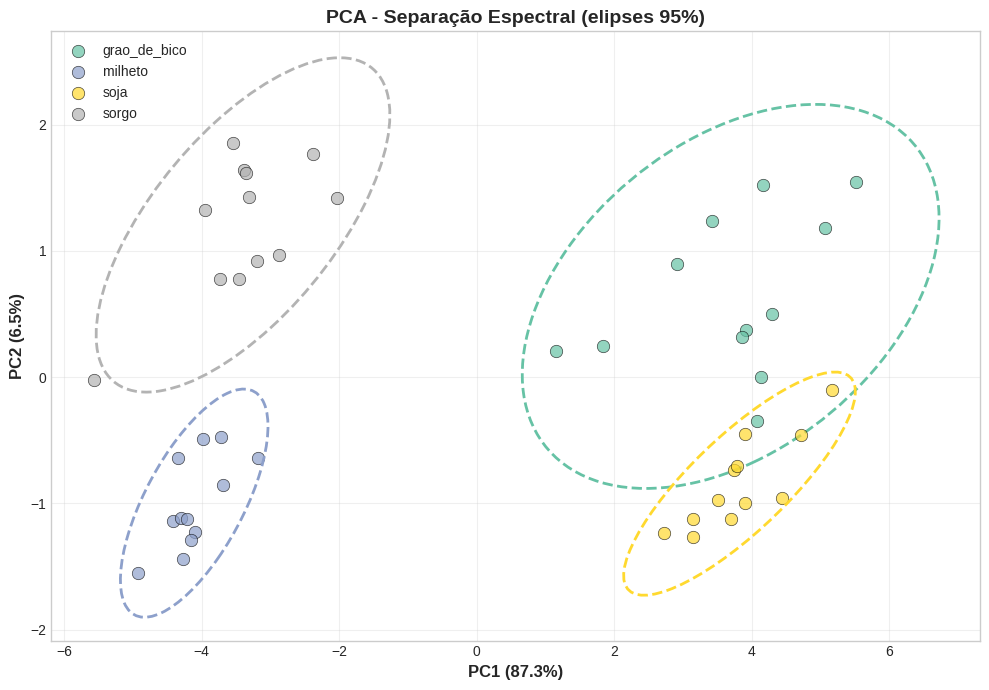

✅ Salvo: pca_scores_pc1_pc2.png


In [6]:
from matplotlib.patches import Ellipse
from scipy.stats import chi2

fig, ax = plt.subplots(figsize=(10, 7))

grains = df_bandas['grain'].values
grain_types = np.unique(grains)
colors = plt.cm.Set2(np.linspace(0, 1, len(grain_types)))

for i, grain in enumerate(grain_types):
    mask = grains == grain
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
               c=[colors[i]], label=grain, s=80, alpha=0.7,
               edgecolors='k', linewidth=0.5)

    points = np.column_stack([X_pca[mask, 0], X_pca[mask, 1]])
    if len(points) > 2:
        mean = points.mean(axis=0)
        cov = np.cov(points.T)
        eigenvalues, eigenvectors = np.linalg.eig(cov)
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
        chisquare_val = chi2.ppf(0.95, 2)
        width, height = 2 * np.sqrt(eigenvalues * chisquare_val)
        ellipse = Ellipse(mean, width, height, angle=angle,
                         facecolor='none', edgecolor=colors[i],
                         linewidth=2, linestyle='--')
        ax.add_patch(ellipse)

ax.set_xlabel(f'PC1 ({var_exp[0]*100:.1f}%)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({var_exp[1]*100:.1f}%)', fontsize=12, fontweight='bold')
ax.set_title('PCA - Separação Espectral (elipses 95%)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('pca_scores_pc1_pc2.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Salvo: pca_scores_pc1_pc2.png")

## 7. Métricas de Confiabilidade (ICC, CV%, SNR)

In [7]:
def calc_icc_anova(values, sample_ids):
    """Calcula ICC usando ANOVA"""
    df_temp = pd.DataFrame({'sample': sample_ids, 'value': values})
    groups = [group['value'].values for name, group in df_temp.groupby('sample')]

    grand_mean = df_temp['value'].mean()
    n_samples = df_temp['sample'].nunique()
    k = len(df_temp) // n_samples

    ssb = sum([k * (group.mean() - grand_mean)**2 for group in groups])
    msb = ssb / (n_samples - 1)

    ssw = sum([((group - group.mean())**2).sum() for group in groups])
    msw = ssw / (len(df_temp) - n_samples)

    icc = (msb - msw) / (msb + (k - 1) * msw)
    return icc

print("\n📏 MÉTRICAS DE CONFIABILIDADE")
print("="*70)

metricas = []
for banda in bandas_r:
    values = df_bandas[banda].values

    icc = calc_icc_anova(values, df_bandas['sample'].values)
    cv_pct = (np.std(values, ddof=1) / np.mean(values)) * 100
    snr = np.mean(values) / np.std(values, ddof=1)

    wavelength = int(banda.replace('r', ''))

    metricas.append({
        'Banda': banda,
        'Wavelength_nm': wavelength,
        'ICC': icc,
        'CV_%': cv_pct,
        'SNR': snr
    })

df_metricas = pd.DataFrame(metricas)

print("\nMétricas por banda:")
display(df_metricas)

print(f"\n📊 RESUMO:")
print(f"  ICC médio: {df_metricas['ICC'].mean():.3f}")
print(f"  CV% médio: {df_metricas['CV_%'].mean():.2f}%")
print(f"  SNR médio: {df_metricas['SNR'].mean():.2f}")

df_metricas.to_csv('metricas_confiabilidade_bandas.csv', index=False)
print("\n✅ Salvo: metricas_confiabilidade_bandas.csv")


📏 MÉTRICAS DE CONFIABILIDADE

Métricas por banda:


Banda  Wavelength_nm       ICC       CV_%        SNR
0   r410            410 -0.080486  10.491393   9.531623
1   r435            435 -0.082112  11.960782   8.360657
2   r460            460 -0.083795  13.566223   7.371248
3   r510            510 -0.085501  15.239083   6.562075
4   r535            535 -0.083061  16.474867   6.069852
5   r560            560 -0.077559  15.063655   6.638495
6   r585            585 -0.089508  16.281056   6.142108
7   r610            610 -0.089598  15.779313   6.337411
8   r645            645 -0.089496  13.464661   7.426848
9   r680            680 -0.085117  14.938675   6.694034
10  r705            705 -0.087028  13.454927   7.432222
11  r730            730 -0.088516  13.331203   7.501198
12  r760            760 -0.080749  11.152245   8.966804
13  r810            810 -0.077366  10.542033   9.485836
14  r860            860  0.011170   6.616009  15.114853
15  r900            900 -0.076923   4.686863  21.336234
16  r940            940 -0.076731   5.126109  19.507973


📊 RESUMO:
  ICC médio: -0.078
  CV% médio: 12.25%
  SNR médio: 9.44

✅ Salvo: metricas_confiabilidade_bandas.csv


## 8. Índices Espectrais (NOVOS - sem banda 485)

In [8]:
print("\n🧬 ÍNDICES ESPECTRAIS (NOVOS - sem banda 485)")
print("="*70)

def calcular_indices_novos(df):
    """
    Índices espectrais SEM usar banda 485nm
    Alinhados com modelo de produção
    """
    df = df.copy()
    df['I1_NDVI'] = (df['r810'] - df['r680']) / (df['r810'] + df['r680'] + 1e-10)
    df['I2_Water'] = df['r940'] / (df['r760'] + 1e-10)
    df['I3_Lipid'] = df['r860'] / (df['r680'] + 1e-10)
    df['I4_Slope_Alt'] = (df['r645'] - df['r535']) / 110.0
    return df

# Calcular índices
df_indices = calcular_indices_novos(df_bandas)
indices_cols = ['I1_NDVI', 'I2_Water', 'I3_Lipid', 'I4_Slope_Alt']

print("\n✅ 4 índices espectrais calculados:")
print("  • I1_NDVI: (r810-r680)/(r810+r680)")
print("  • I2_Water: r940/r760")
print("  • I3_Lipid: r860/r680")
print("  • I4_Slope_Alt: (r645-r535)/110 [SEM r485!]")

print("\n📊 Estatísticas dos índices:")
display(df_indices[indices_cols].describe())

# Adicionar colunas categóricas aos índices
for col in ['sample', 'grain', 'repetition']:
    df_indices[col] = df_bandas[col]

df_indices.to_csv('indices_espectrais_completo.csv', index=False)
print("\n✅ Salvo: indices_espectrais_completo.csv")


🧬 ÍNDICES ESPECTRAIS (NOVOS - sem banda 485)

✅ 4 índices espectrais calculados:
  • I1_NDVI: (r810-r680)/(r810+r680)
  • I2_Water: r940/r760
  • I3_Lipid: r860/r680
  • I4_Slope_Alt: (r645-r535)/110 [SEM r485!]

📊 Estatísticas dos índices:


I1_NDVI   I2_Water   I3_Lipid  I4_Slope_Alt
count  48.000000  48.000000  48.000000     48.000000
mean   -0.011262   1.193330   1.159871      0.000724
std     0.032277   0.086549   0.135445      0.000286
min    -0.077649   1.059615   0.986520      0.000227
25%    -0.035533   1.112040   1.030221      0.000515
50%    -0.016222   1.162588   1.127200      0.000659
75%     0.005155   1.271367   1.268809      0.000990
max     0.057078   1.346154   1.405429      0.001138


✅ Salvo: indices_espectrais_completo.csv


## 9. ANOVA + Tukey dos Índices

In [9]:
print("\n📊 ANOVA + TUKEY DOS ÍNDICES")
print("="*70)

anova_results = []
for idx_col in indices_cols:
    groups = [group[idx_col].values for grain, group in df_indices.groupby('grain')]
    f_stat, p_value = f_oneway(*groups)

    anova_results.append({
        'Indice': idx_col,
        'F_statistic': f_stat,
        'p_value': p_value,
        'Significativo': 'Sim' if p_value < 0.05 else 'Não'
    })

df_anova = pd.DataFrame(anova_results)

print("\nANOVA:")
display(df_anova)

print("\n" + "="*70)
print("TUKEY HSD:")
print("="*70)

tukey_results_all = []
for idx_col in indices_cols:
    tukey = pairwise_tukeyhsd(df_indices[idx_col], df_indices['grain'], alpha=0.05)
    print(f"\n{idx_col}:")
    print(tukey)

    tukey_df = pd.DataFrame(data=tukey.summary().data[1:],
                           columns=tukey.summary().data[0])
    tukey_df['Indice'] = idx_col
    tukey_results_all.append(tukey_df)

df_tukey = pd.concat(tukey_results_all, ignore_index=True)

df_anova.to_csv('anova_indices.csv', index=False)
df_tukey.to_csv('tukey_indices.csv', index=False)
print("\n✅ Salvo: anova_indices.csv")
print("✅ Salvo: tukey_indices.csv")

sig_count = (df_anova['p_value'] < 0.05).sum()
print(f"\n📊 {sig_count}/4 índices significativos (p < 0.05)")


📊 ANOVA + TUKEY DOS ÍNDICES

ANOVA:


Indice  F_statistic       p_value Significativo
0       I1_NDVI    54.746695  6.752552e-15           Sim
1      I2_Water    81.413594  5.470424e-18           Sim
2      I3_Lipid   152.180453  3.021104e-23           Sim
3  I4_Slope_Alt    70.806462  7.096815e-17           Sim


TUKEY HSD:

I1_NDVI:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
   group1     group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------------
grao_de_bico milheto   0.0733    0.0  0.0566    0.09   True
grao_de_bico    soja   0.0084 0.5384 -0.0083  0.0252  False
grao_de_bico   sorgo   0.0261 0.0008  0.0094  0.0428   True
     milheto    soja  -0.0649    0.0 -0.0816 -0.0482   True
     milheto   sorgo  -0.0472    0.0 -0.0639 -0.0305   True
        soja   sorgo   0.0177 0.0344   0.001  0.0344   True
-----------------------------------------------------------

I2_Water:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
   group1     group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------------
grao_de_bico milheto   0.2085    0.0  0.1704  0.2466   True
grao_de_bico    soja   0.0386 0.0462  0.0005  0.0767   True
grao_de_bico   sorgo   0.1003    0.0  0.0622  0.1384   True
     mi

## 10. PERMANOVA

In [10]:
def permanova(X, groups, n_permutations=999, seed=123):
    """PERMANOVA com distância Euclidiana"""
    np.random.seed(seed)

    n = len(groups)
    unique_groups = np.unique(groups)
    n_groups = len(unique_groups)

    centroid = X.mean(axis=0)
    sst = np.sum((X - centroid)**2)

    ssw = 0
    for group in unique_groups:
        group_data = X[groups == group]
        group_centroid = group_data.mean(axis=0)
        ssw += np.sum((group_data - group_centroid)**2)

    ssb = sst - ssw

    df_between = n_groups - 1
    df_within = n - n_groups

    msb = ssb / df_between
    msw = ssw / df_within

    F_obs = msb / msw
    r2 = ssb / sst

    F_perms = []
    for _ in range(n_permutations):
        groups_perm = np.random.permutation(groups)

        ssw_perm = 0
        for group in unique_groups:
            group_data = X[groups_perm == group]
            if len(group_data) > 0:
                group_centroid = group_data.mean(axis=0)
                ssw_perm += np.sum((group_data - group_centroid)**2)

        ssb_perm = sst - ssw_perm
        msb_perm = ssb_perm / df_between
        msw_perm = ssw_perm / df_within
        F_perms.append(msb_perm / msw_perm)

    p_value = np.mean(np.array(F_perms) >= F_obs)

    return {
        'F': F_obs,
        'p_value': p_value,
        'R2': r2,
        'df_between': df_between,
        'df_within': df_within,
        'SSB': ssb,
        'SST': sst
    }

print("\n📊 PERMANOVA (média por amostra)")
print("="*70)

result = permanova(X_avg_scaled, df_avg['grain'].values, n_permutations=999, seed=123)

print(f"\n✅ RESULTADOS:")
print(f"  Pseudo-F: {result['F']:.2f}")
print(f"  p-valor: {result['p_value']:.3f}")
print(f"  R²: {result['R2']:.3f} ({result['R2']*100:.1f}%)")

if result['p_value'] < 0.05:
    print("\n✅ Diferenças SIGNIFICATIVAS (p < 0.05)")
else:
    print("\n⚠️  Diferenças NÃO significativas")

df_permanova = pd.DataFrame([{
    'Termo': 'Model',
    'Df': result['df_between'],
    'SumOfSqs': result['SSB'],
    'R2': result['R2'],
    'F': result['F'],
    'Pr(>F)': result['p_value']
}])

df_permanova.to_csv('permanova_media_por_amostra.csv', index=False)
print("\n✅ Salvo: permanova_media_por_amostra.csv")


📊 PERMANOVA (média por amostra)

✅ RESULTADOS:
  Pseudo-F: 62.01
  p-valor: 0.000
  R²: 0.939 (93.9%)

✅ Diferenças SIGNIFICATIVAS (p < 0.05)

✅ Salvo: permanova_media_por_amostra.csv


## 11. Preparação Features para Modelo

In [11]:
print("\n🔧 PREPARAÇÃO DE FEATURES")
print("="*70)

# Arrays de índices e PCs
indices_array = df_indices[indices_cols].values
pcs_array = X_pca[:, :6]  # 6 primeiros PCs

# Combinar: 4 índices + 6 PCs = 10 features
X_features = np.hstack([indices_array, pcs_array])

# Padronizar features
scaler_features = StandardScaler()
X_features_scaled = scaler_features.fit_transform(X_features)

# Labels e grupos
y_labels = df_bandas['grain'].values
groups = df_bandas['sample'].values

print(f"\n✅ Features preparadas:")
print(f"  Shape: {X_features_scaled.shape}")
print(f"  4 índices + 6 PCs = 10 features")
print(f"  Classes: {np.unique(y_labels)}")
print(f"  Amostras únicas: {len(np.unique(groups))}")


🔧 PREPARAÇÃO DE FEATURES

✅ Features preparadas:
  Shape: (48, 10)
  4 índices + 6 PCs = 10 features
  Classes: ['grao_de_bico' 'milheto' 'soja' 'sorgo']
  Amostras únicas: 4


## 12. Modelo SVM com Validação LOSO

In [12]:
print("\n🤖 MODELO SVM - VALIDAÇÃO LOSO")
print("="*70)
print("\n📝 LOSO = Leave-One-Sample-Out")
print("   Cada amostra testada 1 vez, demais para treino\n")

logo = LeaveOneGroupOut()
n_splits = logo.get_n_splits(X_features_scaled, y_labels, groups)

print(f"LOSO splits: {n_splits}\n")

acuracias = []
f1_scores = []
balanced_accs = []
fold = 1

for train_idx, test_idx in logo.split(X_features_scaled, y_labels, groups):
    X_train, X_test = X_features_scaled[train_idx], X_features_scaled[test_idx]
    y_train, y_test = y_labels[train_idx], y_labels[test_idx]

    svm = SVC(kernel='linear', C=1.0, random_state=42)
    svm.fit(X_train, y_train)

    y_pred = svm.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    bacc = balanced_accuracy_score(y_test, y_pred)

    acuracias.append(acc)
    f1_scores.append(f1)
    balanced_accs.append(bacc)

    sample_out = np.unique(groups[test_idx])[0]
    print(f"Fold {fold:2d} (Amostra {sample_out} OUT): Acc={acc:.3f}, F1={f1:.3f}")
    fold += 1

print("\n" + "="*70)
print(f"📊 RESULTADOS LOSO:")
print(f"  Accuracy: {np.mean(acuracias):.3f} ± {np.std(acuracias):.3f}")
print(f"  F1-Score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")
print(f"  Balanced Acc: {np.mean(balanced_accs):.3f} ± {np.std(balanced_accs):.3f}")

df_cv = pd.DataFrame({
    'Fold': range(1, len(acuracias) + 1),
    'Sample_Out': [np.unique(groups[test_idx])[0]
                   for train_idx, test_idx in logo.split(X_features_scaled, y_labels, groups)],
    'Accuracy': acuracias,
    'F1_Score': f1_scores,
    'Balanced_Accuracy': balanced_accs
})

df_cv.to_csv('validacao_loso.csv', index=False)
print("\n✅ Salvo: validacao_loso.csv")


🤖 MODELO SVM - VALIDAÇÃO LOSO

📝 LOSO = Leave-One-Sample-Out
   Cada amostra testada 1 vez, demais para treino

LOSO splits: 4

Fold  1 (Amostra 1 OUT): Acc=1.000, F1=1.000
Fold  2 (Amostra 2 OUT): Acc=1.000, F1=1.000
Fold  3 (Amostra 3 OUT): Acc=1.000, F1=1.000
Fold  4 (Amostra 4 OUT): Acc=0.917, F1=0.914

📊 RESULTADOS LOSO:
  Accuracy: 0.979 ± 0.036
  F1-Score: 0.979 ± 0.037
  Balanced Acc: 0.979 ± 0.036

✅ Salvo: validacao_loso.csv


## 13. Treinar Modelo Final

In [13]:
print("\n🎯 TREINAMENTO DO MODELO FINAL")
print("="*70)

modelo_especies = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
modelo_especies.fit(X_features_scaled, y_labels)

y_pred_final = modelo_especies.predict(X_features_scaled)

print("\n📊 RELATÓRIO DE CLASSIFICAÇÃO:")
print(classification_report(y_labels, y_pred_final))

cm = confusion_matrix(y_labels, y_pred_final)
print("\n📊 MATRIZ DE CONFUSÃO:")
print(cm)

acc_final = accuracy_score(y_labels, y_pred_final)
print(f"\n✅ Acurácia: {acc_final:.3f} ({acc_final*100:.1f}%)")

print(f"\n🌾 Espécies detectadas: {list(modelo_especies.classes_)}")


🎯 TREINAMENTO DO MODELO FINAL

📊 RELATÓRIO DE CLASSIFICAÇÃO:
              precision    recall  f1-score   support

grao_de_bico       1.00      1.00      1.00        12
     milheto       1.00      1.00      1.00        12
        soja       1.00      1.00      1.00        12
       sorgo       1.00      1.00      1.00        12

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48


📊 MATRIZ DE CONFUSÃO:
[[12  0  0  0]
 [ 0 12  0  0]
 [ 0  0 12  0]
 [ 0  0  0 12]]

✅ Acurácia: 1.000 (100.0%)

🌾 Espécies detectadas: ['grao_de_bico', 'milheto', 'soja', 'sorgo']


## 14. DETECÇÃO DE ANOMALIA - One-Class SVM

In [14]:
print("\n🔍 TREINAMENTO DE DETECÇÃO DE ANOMALIA")
print("="*70)
print("\nTreinando One-Class SVM para cada espécie...\n")

# Scaler para índices (usado na detecção de anomalia)
scaler_indices = StandardScaler()
indices_scaled = scaler_indices.fit_transform(indices_array)

# Dicionário de detectores (um por espécie)
detectores_anomalia = {}

for especie in modelo_especies.classes_:
    # Pegar apenas dados PUROS da espécie
    mask_especie = (y_labels == especie)
    indices_especie = indices_scaled[mask_especie]

    # Treinar One-Class SVM
    oc_svm = OneClassSVM(
        kernel='rbf',
        nu=0.05,  # 5% de outliers esperados
        gamma='auto'
    )
    oc_svm.fit(indices_especie)

    detectores_anomalia[especie] = oc_svm

    # Testar no próprio conjunto de treino
    predictions = oc_svm.predict(indices_especie)
    n_inliers = np.sum(predictions == 1)
    n_outliers = np.sum(predictions == -1)

    print(f"✅ {especie}:")
    print(f"   Amostras treino: {len(indices_especie)}")
    print(f"   Inliers: {n_inliers} ({n_inliers/len(indices_especie)*100:.1f}%)")
    print(f"   Outliers: {n_outliers} ({n_outliers/len(indices_especie)*100:.1f}%)")

print(f"\n✅ {len(detectores_anomalia)} detectores treinados!")


🔍 TREINAMENTO DE DETECÇÃO DE ANOMALIA

Treinando One-Class SVM para cada espécie...

✅ grao_de_bico:
   Amostras treino: 12
   Inliers: 10 (83.3%)
   Outliers: 2 (16.7%)
✅ milheto:
   Amostras treino: 12
   Inliers: 9 (75.0%)
   Outliers: 3 (25.0%)
✅ soja:
   Amostras treino: 12
   Inliers: 10 (83.3%)
   Outliers: 2 (16.7%)
✅ sorgo:
   Amostras treino: 12
   Inliers: 11 (91.7%)
   Outliers: 1 (8.3%)

✅ 4 detectores treinados!


## 15. DETECÇÃO DE ANOMALIA - Limiares MAD

In [15]:
print("\n📏 CÁLCULO DE LIMIARES MAD")
print("="*70)
print("\nMAD = Median Absolute Deviation")
print("Fator de escala: 2.5 (robusto a outliers)\n")

limiares_mad = {}

for especie in modelo_especies.classes_:
    mask_especie = (y_labels == especie)
    indices_especie = indices_scaled[mask_especie]

    # Calcular mediana
    medians = np.median(indices_especie, axis=0)

    # Calcular MAD (com fator 2.5 para robustez)
    mads = np.median(np.abs(indices_especie - medians), axis=0) * 2.5

    limiares_mad[especie] = {
        'medians': medians,
        'mads': mads
    }

    print(f"✅ {especie}:")
    for i, idx_name in enumerate(indices_cols):
        print(f"   {idx_name}: mediana={medians[i]:.4f}, MAD={mads[i]:.4f}")
    print()

print(f"✅ Limiares calculados para {len(limiares_mad)} espécies!")


📏 CÁLCULO DE LIMIARES MAD

MAD = Median Absolute Deviation
Fator de escala: 2.5 (robusto a outliers)

✅ grao_de_bico:
   I1_NDVI: mediana=-0.7934, MAD=0.7029
   I2_Water: mediana=-0.9492, MAD=0.1553
   I3_Lipid: mediana=-0.8899, MAD=0.5166
   I4_Slope_Alt: mediana=0.8917, MAD=0.7145

✅ milheto:
   I1_NDVI: mediana=1.6547, MAD=0.7335
   I2_Water: mediana=1.7844, MAD=0.0000
   I3_Lipid: mediana=1.3384, MAD=0.6614
   I4_Slope_Alt: mediana=-1.2446, MAD=0.6419

✅ soja:
   I1_NDVI: mediana=-0.5410, MAD=0.6010
   I2_Water: mediana=-0.3590, MAD=0.0000
   I3_Lipid: mediana=-0.9806, MAD=0.2739
   I4_Slope_Alt: mediana=-0.4650, MAD=0.4493

✅ sorgo:
   I1_NDVI: mediana=0.0126, MAD=0.4197
   I2_Water: mediana=0.1299, MAD=0.0000
   I3_Lipid: mediana=0.5468, MAD=0.3356
   I4_Slope_Alt: mediana=1.1319, MAD=0.4927

✅ Limiares calculados para 4 espécies!


## 16. Salvar Modelo Completo (UM único PKL)

In [16]:
print("\n💾 SALVANDO MODELO COMPLETO")
print("="*70)

# Criar dicionário com TODOS os componentes
modelo_completo = {
    # Modelo de classificação
    'modelo_especies': modelo_especies,

    # Detecção de anomalia
    'detectores_anomalia': detectores_anomalia,
    'limiares_mad': limiares_mad,

    # Scalers
    'scaler_bandas': scaler_bandas,      # Para 17 bandas
    'scaler_indices': scaler_indices,    # Para 4 índices
    'scaler_final': scaler_features,     # Para 10 features

    # PCA
    'pca': pca,

    # Nomes das colunas
    'bandas_cols': bandas_r,             # 17 bandas (r410, r435, ..., r940 SEM r485)
    'indices_cols': indices_cols         # 4 índices novos
}

# Salvar
joblib.dump(modelo_completo, 'modelo_completo_sem_485nm.pkl')

print("\n✅ Modelo salvo: modelo_completo_sem_485nm.pkl")
print("\n📦 CONTEÚDO DO MODELO:")
print("  1. modelo_especies: SVM classificador")
print(f"     Classes: {list(modelo_especies.classes_)}")
print("\n  2. detectores_anomalia: One-Class SVM por espécie")
for especie in detectores_anomalia.keys():
    print(f"     - {especie}: {type(detectores_anomalia[especie]).__name__}")
print("\n  3. limiares_mad: Limiares estatísticos por espécie")
for especie in limiares_mad.keys():
    print(f"     - {especie}: medians + mads")
print("\n  4. scaler_bandas: StandardScaler para 17 bandas")
print("  5. scaler_indices: StandardScaler para 4 índices")
print("  6. scaler_final: StandardScaler para 10 features")
print("  7. pca: PCA com 17 componentes")
print(f"     Variância 6 PCs: {pca.explained_variance_ratio_[:6].sum()*100:.2f}%")
print(f"\n  8. bandas_cols: {len(bandas_r)} bandas")
print(f"     {bandas_r}")
print(f"\n  9. indices_cols: {len(indices_cols)} índices")
print(f"     {indices_cols}")

# Verificar tamanho do arquivo
import os
tamanho_mb = os.path.getsize('modelo_completo_sem_485nm.pkl') / (1024 * 1024)
print(f"\n📊 Tamanho do arquivo: {tamanho_mb:.2f} MB")

print("\n" + "="*70)
print("✅ MODELO PRONTO PARA PRODUÇÃO!")
print("="*70)


💾 SALVANDO MODELO COMPLETO

✅ Modelo salvo: modelo_completo_sem_485nm.pkl

📦 CONTEÚDO DO MODELO:
  1. modelo_especies: SVM classificador
     Classes: ['grao_de_bico', 'milheto', 'soja', 'sorgo']

  2. detectores_anomalia: One-Class SVM por espécie
     - grao_de_bico: OneClassSVM
     - milheto: OneClassSVM
     - soja: OneClassSVM
     - sorgo: OneClassSVM

  3. limiares_mad: Limiares estatísticos por espécie
     - grao_de_bico: medians + mads
     - milheto: medians + mads
     - soja: medians + mads
     - sorgo: medians + mads

  4. scaler_bandas: StandardScaler para 17 bandas
  5. scaler_indices: StandardScaler para 4 índices
  6. scaler_final: StandardScaler para 10 features
  7. pca: PCA com 17 componentes
     Variância 6 PCs: 99.35%

  8. bandas_cols: 17 bandas
     ['r410', 'r435', 'r460', 'r510', 'r535', 'r560', 'r585', 'r610', 'r645', 'r680', 'r705', 'r730', 'r760', 'r810', 'r860', 'r900', 'r940']

  9. indices_cols: 4 índices
     ['I1_NDVI', 'I2_Water', 'I3_Lipid', 'I4

## 17. Testar Inferência (simulando Flask)

In [17]:
print("\n🧪 TESTE DE INFERÊNCIA (Simulando Flask)")
print("="*70)

# Recarregar modelo (simular Flask)
MODELO = joblib.load('modelo_completo_sem_485nm.pkl')

print("\n✅ Modelo recarregado com sucesso!")
print(f"   Espécies: {list(MODELO['modelo_especies'].classes_)}")
print(f"   Bandas: {len(MODELO['bandas_cols'])}")
print(f"   Índices: {len(MODELO['indices_cols'])}")

# Pegar uma amostra aleatória para testar
idx_teste = 0
spectrum_teste = X_raw[idx_teste, :]  # 17 bandas
especie_real = y_labels[idx_teste]

print(f"\n🔬 TESTE COM AMOSTRA {idx_teste}:")
print(f"   Espécie real: {especie_real}")
print(f"   Espectro shape: {spectrum_teste.shape}")

# Simular função de inferência
def prever_amostra_teste(spectrum):
    """Simula inferência do Flask"""

    # 1. Criar DataFrame com bandas
    bandas_dict = {MODELO['bandas_cols'][i]: spectrum[i] for i in range(17)}
    df_temp = pd.DataFrame([bandas_dict])

    # 2. Calcular índices
    df_temp = calcular_indices_novos(df_temp)
    indices_array = df_temp[MODELO['indices_cols']].values

    # 3. Processar bandas com PCA
    bandas_array = np.array(spectrum).reshape(1, -1)
    bandas_scaled = MODELO['scaler_bandas'].transform(bandas_array)
    pca_array = MODELO['pca'].transform(bandas_scaled)

    # 4. Combinar features
    X_completo = np.hstack([indices_array, pca_array[:, :6]])
    X_completo_scaled = MODELO['scaler_final'].transform(X_completo)

    # 5. Predição de espécie
    especie_pred = MODELO['modelo_especies'].predict(X_completo_scaled)[0]
    prob_especies = MODELO['modelo_especies'].predict_proba(X_completo_scaled)[0]
    confianca = float(np.max(prob_especies))

    # 6. Detecção de anomalia - One-Class SVM
    indices_scaled = MODELO['scaler_indices'].transform(indices_array)
    decisao_svm = MODELO['detectores_anomalia'][especie_pred].predict(indices_scaled)[0]
    score_svm = MODELO['detectores_anomalia'][especie_pred].decision_function(indices_scaled)[0]
    anomalia_svm = (decisao_svm == -1)

    # 7. Detecção de anomalia - MAD
    limiar = MODELO['limiares_mad'][especie_pred]
    desvios = np.abs(indices_scaled[0] - limiar['medians'])
    violacoes = np.sum(desvios > limiar['mads'])
    anomalia_mad = (violacoes >= 3)

    # 8. Status final (lógica AND)
    status = "ANORMAL" if (anomalia_svm and anomalia_mad) else "NORMAL"

    return {
        'especie': especie_pred,
        'confianca': round(confianca * 100, 1),
        'status': status,
        'probabilidades': {
            classe: round(float(prob) * 100, 1)
            for classe, prob in zip(MODELO['modelo_especies'].classes_, prob_especies)
        },
        'indices': {
            col: round(float(val), 4)
            for col, val in zip(MODELO['indices_cols'], indices_array[0])
        },
        'detalhes_anomalia': {
            'svm_score': round(float(score_svm), 4),
            'svm_detectou': bool(anomalia_svm),
            'mad_violacoes': int(violacoes),
            'mad_detectou': bool(anomalia_mad),
            'logica': 'AND (ambos devem concordar)'
        }
    }

# Executar teste
resultado = prever_amostra_teste(spectrum_teste)

print("\n📊 RESULTADO DA INFERÊNCIA:")
print(f"   Espécie predita: {resultado['especie']}")
print(f"   Confiança: {resultado['confianca']}%")
print(f"   Status: {resultado['status']}")
print(f"\n   Probabilidades:")
for esp, prob in resultado['probabilidades'].items():
    print(f"     {esp}: {prob}%")
print(f"\n   Índices:")
for idx, val in resultado['indices'].items():
    print(f"     {idx}: {val}")
print(f"\n   Detecção de Anomalia:")
print(f"     SVM Score: {resultado['detalhes_anomalia']['svm_score']}")
print(f"     SVM Detectou: {resultado['detalhes_anomalia']['svm_detectou']}")
print(f"     MAD Violações: {resultado['detalhes_anomalia']['mad_violacoes']}/4")
print(f"     MAD Detectou: {resultado['detalhes_anomalia']['mad_detectou']}")
print(f"     Lógica: {resultado['detalhes_anomalia']['logica']}")

# Verificar se acertou
if resultado['especie'] == especie_real:
    print("\n✅ PREDIÇÃO CORRETA!")
else:
    print(f"\n❌ PREDIÇÃO INCORRETA! (esperado: {especie_real})")


🧪 TESTE DE INFERÊNCIA (Simulando Flask)

✅ Modelo recarregado com sucesso!
   Espécies: ['grao_de_bico', 'milheto', 'soja', 'sorgo']
   Bandas: 17
   Índices: 4

🔬 TESTE COM AMOSTRA 0:
   Espécie real: soja
   Espectro shape: (17,)

📊 RESULTADO DA INFERÊNCIA:
   Espécie predita: soja
   Confiança: 91.3%
   Status: ANORMAL

   Probabilidades:
     grao_de_bico: 3.0%
     milheto: 3.3%
     soja: 91.3%
     sorgo: 2.4%

   Índices:
     I1_NDVI: -0.0435
     I2_Water: 1.1427
     I3_Lipid: 0.9865
     I4_Slope_Alt: 0.0003

   Detecção de Anomalia:
     SVM Score: -0.0002
     SVM Detectou: True
     MAD Violações: 3/4
     MAD Detectou: True
     Lógica: AND (ambos devem concordar)

✅ PREDIÇÃO CORRETA!


## 18. Resumo Final

In [18]:
print("\n" + "="*80)
print("📊 RESUMO FINAL - SISTEMA COMPLETO")
print("="*80)

print("\n1️⃣ DADOS")
print("-" * 80)
print(f"  Bandas: {len(bandas_r)} (removida: 485nm)")
print(f"  Índices: {len(indices_cols)} (novos, sem 485nm)")
print(f"  Grãos: {len(np.unique(y_labels))}")
print(f"  Medições: {len(y_labels)}")

print("\n2️⃣ SEPARABILIDADE ESPECTRAL")
print("-" * 80)
print(f"PERMANOVA:")
print(f"  • Pseudo-F: {result['F']:.2f}")
print(f"  • R²: {result['R2']:.3f} ({result['R2']*100:.1f}%)")
print(f"  • p-valor: {result['p_value']:.3f}")
print(f"\nPCA:")
print(f"  • PC1: {var_exp[0]*100:.2f}%")
print(f"  • PC1+PC2: {var_cum[1]*100:.2f}%")
print(f"  • 6 PCs: {var_cum[5]*100:.2f}%")

print("\n3️⃣ REPRODUTIBILIDADE")
print("-" * 80)
print(f"  ICC médio: {df_metricas['ICC'].mean():.3f}")
print(f"  CV% médio: {df_metricas['CV_%'].mean():.2f}%")
print(f"  SNR médio: {df_metricas['SNR'].mean():.2f}")

print("\n4️⃣ ÍNDICES ESPECTRAIS")
print("-" * 80)
sig_indices = (df_anova['p_value'] < 0.05).sum()
print(f"  Significativos (ANOVA): {sig_indices}/4")
print(f"  Todos SEM usar banda 485nm ✅")

print("\n5️⃣ MODELO DE CLASSIFICAÇÃO")
print("-" * 80)
print(f"  Algoritmo: SVM Linear")
print(f"  Features: 4 índices + 6 PCs = 10 dimensões")
print(f"  Validação LOSO:")
print(f"    • Accuracy: {np.mean(acuracias):.3f} ± {np.std(acuracias):.3f}")
print(f"    • F1-Score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")
print(f"  Conjunto completo: {acc_final:.3f}")

print("\n6️⃣ DETECÇÃO DE ANOMALIA")
print("-" * 80)
print(f"  One-Class SVM:")
print(f"    • Kernel: RBF")
print(f"    • Nu: 0.05 (5% outliers esperados)")
print(f"    • Detectores: {len(detectores_anomalia)} (um por espécie)")
print(f"\n  Limiares MAD:")
print(f"    • Método: Median Absolute Deviation")
print(f"    • Fator: 2.5 (robusto)")
print(f"    • Violações mínimas: 3/4 índices")
print(f"\n  Lógica de decisão: AND (ambos devem concordar)")

print("\n7️⃣ ARQUIVOS GERADOS")
print("-" * 80)
print("  📊 CSVs de análise:")
print("    • pca_variancia.csv")
print("    • metricas_confiabilidade_bandas.csv")
print("    • indices_espectrais_completo.csv")
print("    • anova_indices.csv")
print("    • tukey_indices.csv")
print("    • permanova_media_por_amostra.csv")
print("    • validacao_loso.csv")
print("\n  💾 Modelo para produção:")
print("    • modelo_completo_sem_485nm.pkl (TUDO EM UM ARQUIVO!)")
print("\n  📈 Figuras:")
print("    • pca_scores_pc1_pc2.png")

print("\n8️⃣ COMPATIBILIDADE ESP32/FLASK")
print("-" * 80)
print("  ✅ Flask pode receber 18 bandas do ESP32")
print("  ✅ Remove banda 485 automaticamente")
print("  ✅ Calcula índices novos (sem 485)")
print("  ✅ Retorna classificação + detecção de anomalia")
print("  ✅ Formato idêntico ao sistema anterior")

print("\n" + "="*80)
print("✅ SISTEMA COMPLETO - PRONTO PARA PRODUÇÃO!")
print("="*80)
print("\n💡 Próximos passos:")
print("  1. Baixar 'modelo_completo_sem_485nm.pkl'")
print("  2. Usar com servidor Flask adaptado")
print("  3. ESP32 continua enviando 18 bandas (Flask remove 485)")
print("  4. Sistema funcionará igual às imagens mostradas!")


📊 RESUMO FINAL - SISTEMA COMPLETO

1️⃣ DADOS
--------------------------------------------------------------------------------
  Bandas: 17 (removida: 485nm)
  Índices: 4 (novos, sem 485nm)
  Grãos: 4
  Medições: 48

2️⃣ SEPARABILIDADE ESPECTRAL
--------------------------------------------------------------------------------
PERMANOVA:
  • Pseudo-F: 62.01
  • R²: 0.939 (93.9%)
  • p-valor: 0.000

PCA:
  • PC1: 87.34%
  • PC1+PC2: 93.87%
  • 6 PCs: 99.35%

3️⃣ REPRODUTIBILIDADE
--------------------------------------------------------------------------------
  ICC médio: -0.078
  CV% médio: 12.25%
  SNR médio: 9.44

4️⃣ ÍNDICES ESPECTRAIS
--------------------------------------------------------------------------------
  Significativos (ANOVA): 4/4
  Todos SEM usar banda 485nm ✅

5️⃣ MODELO DE CLASSIFICAÇÃO
--------------------------------------------------------------------------------
  Algoritmo: SVM Linear
  Features: 4 índices + 6 PCs = 10 dimensões
  Validação LOSO:
    • Accuracy: 


📈 GERANDO GRÁFICOS PROFISSIONAIS

1️⃣ Gráfico de linhas: ICC, CV%, SNR por banda...


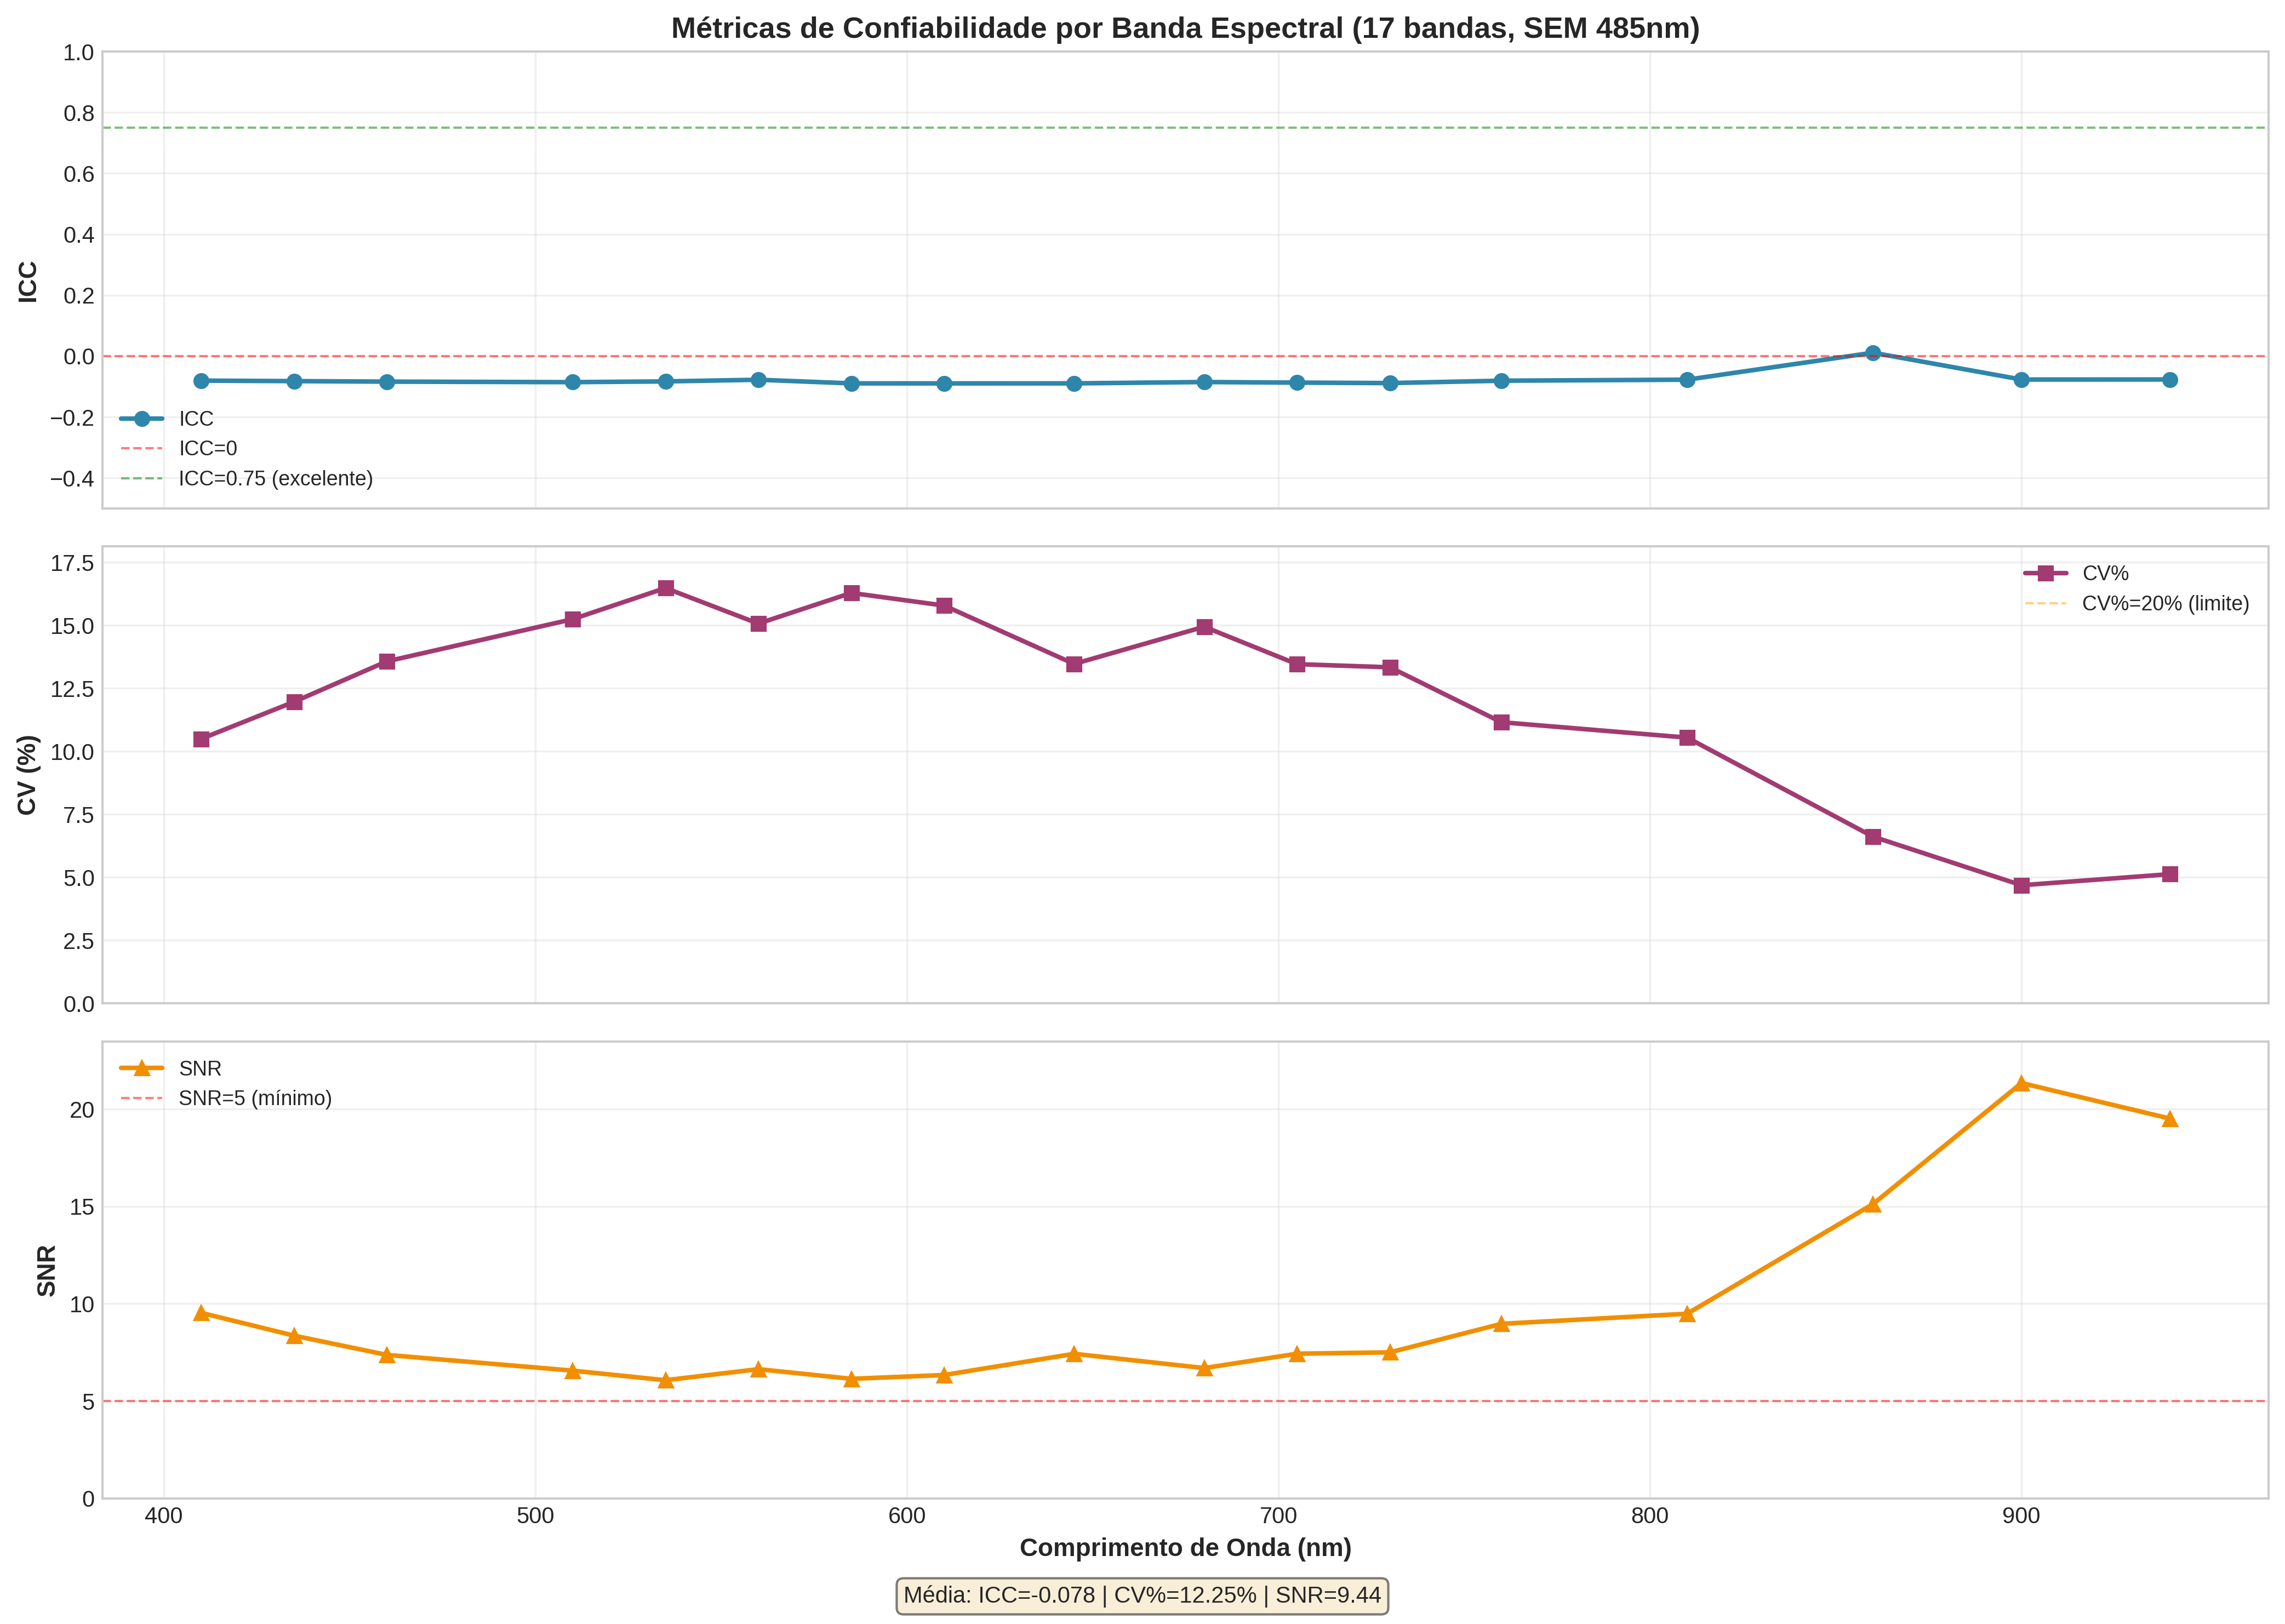

✅ Salvo: metricas_ICC_CV_SNR_linhas.png

2️⃣ Assinaturas espectrais médias por tipo de grão...


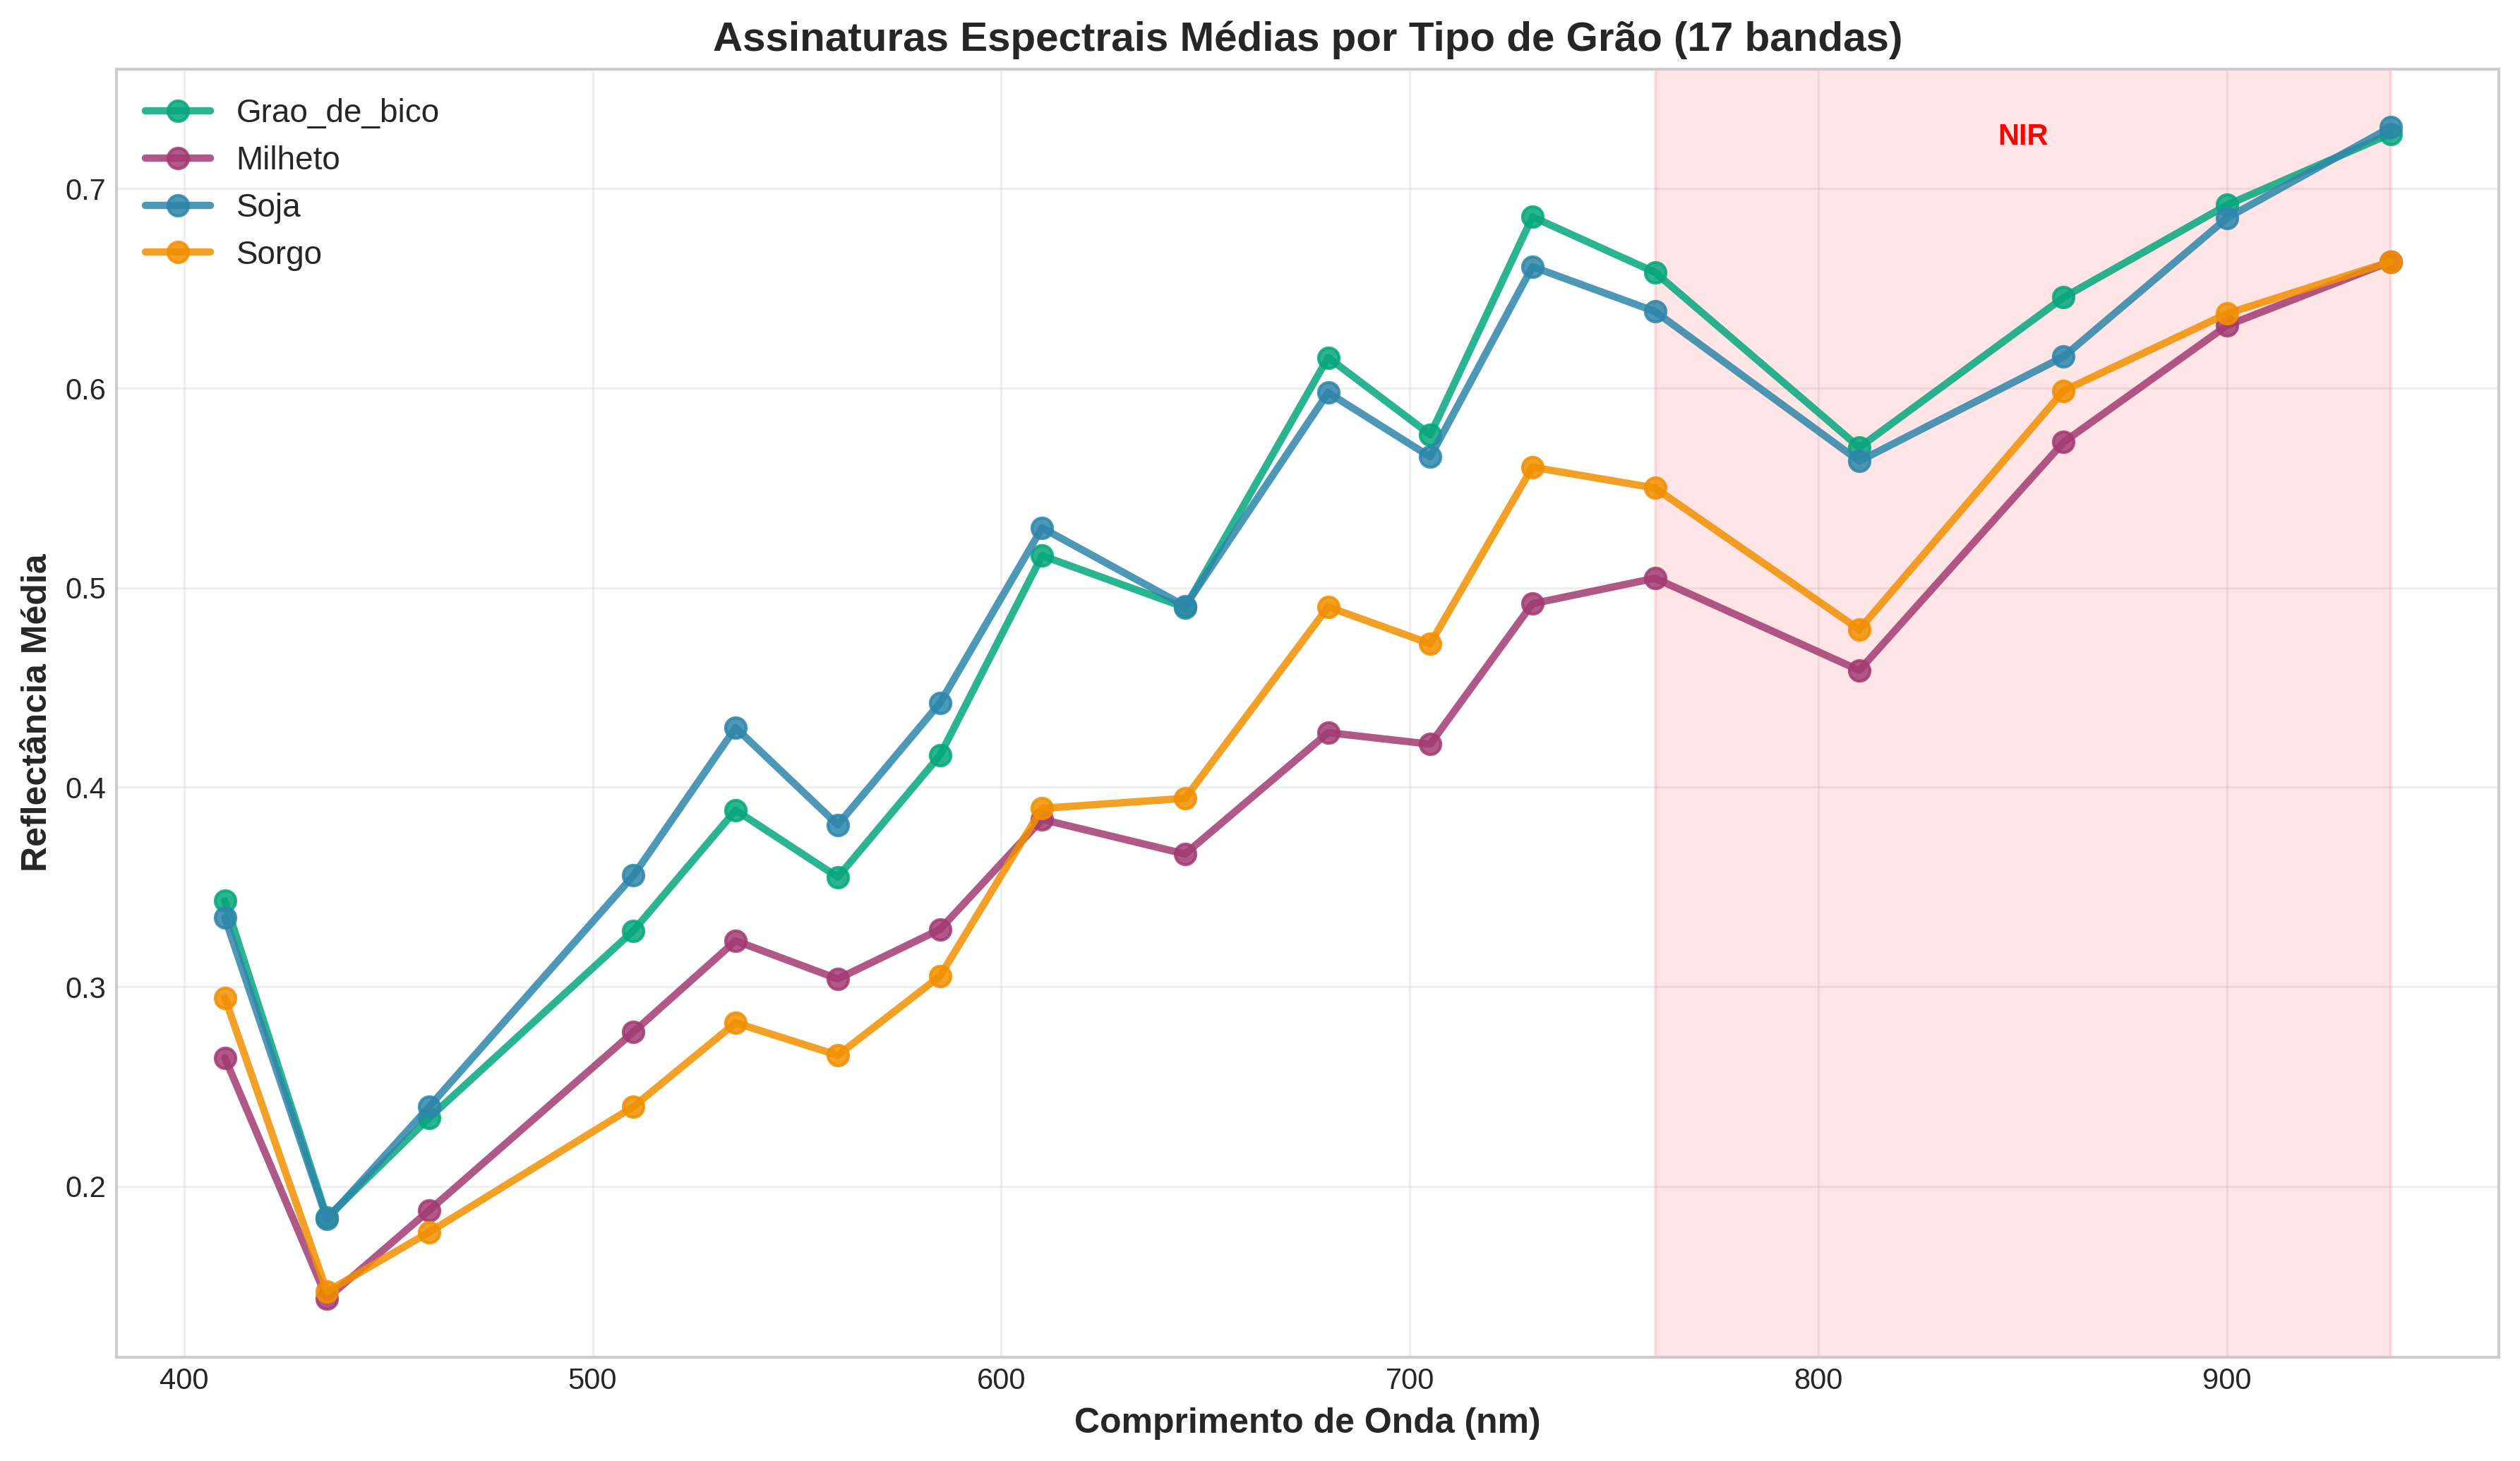

✅ Salvo: assinaturas_espectrais_por_grao.png

3️⃣ Regressão: ICC vs SNR...


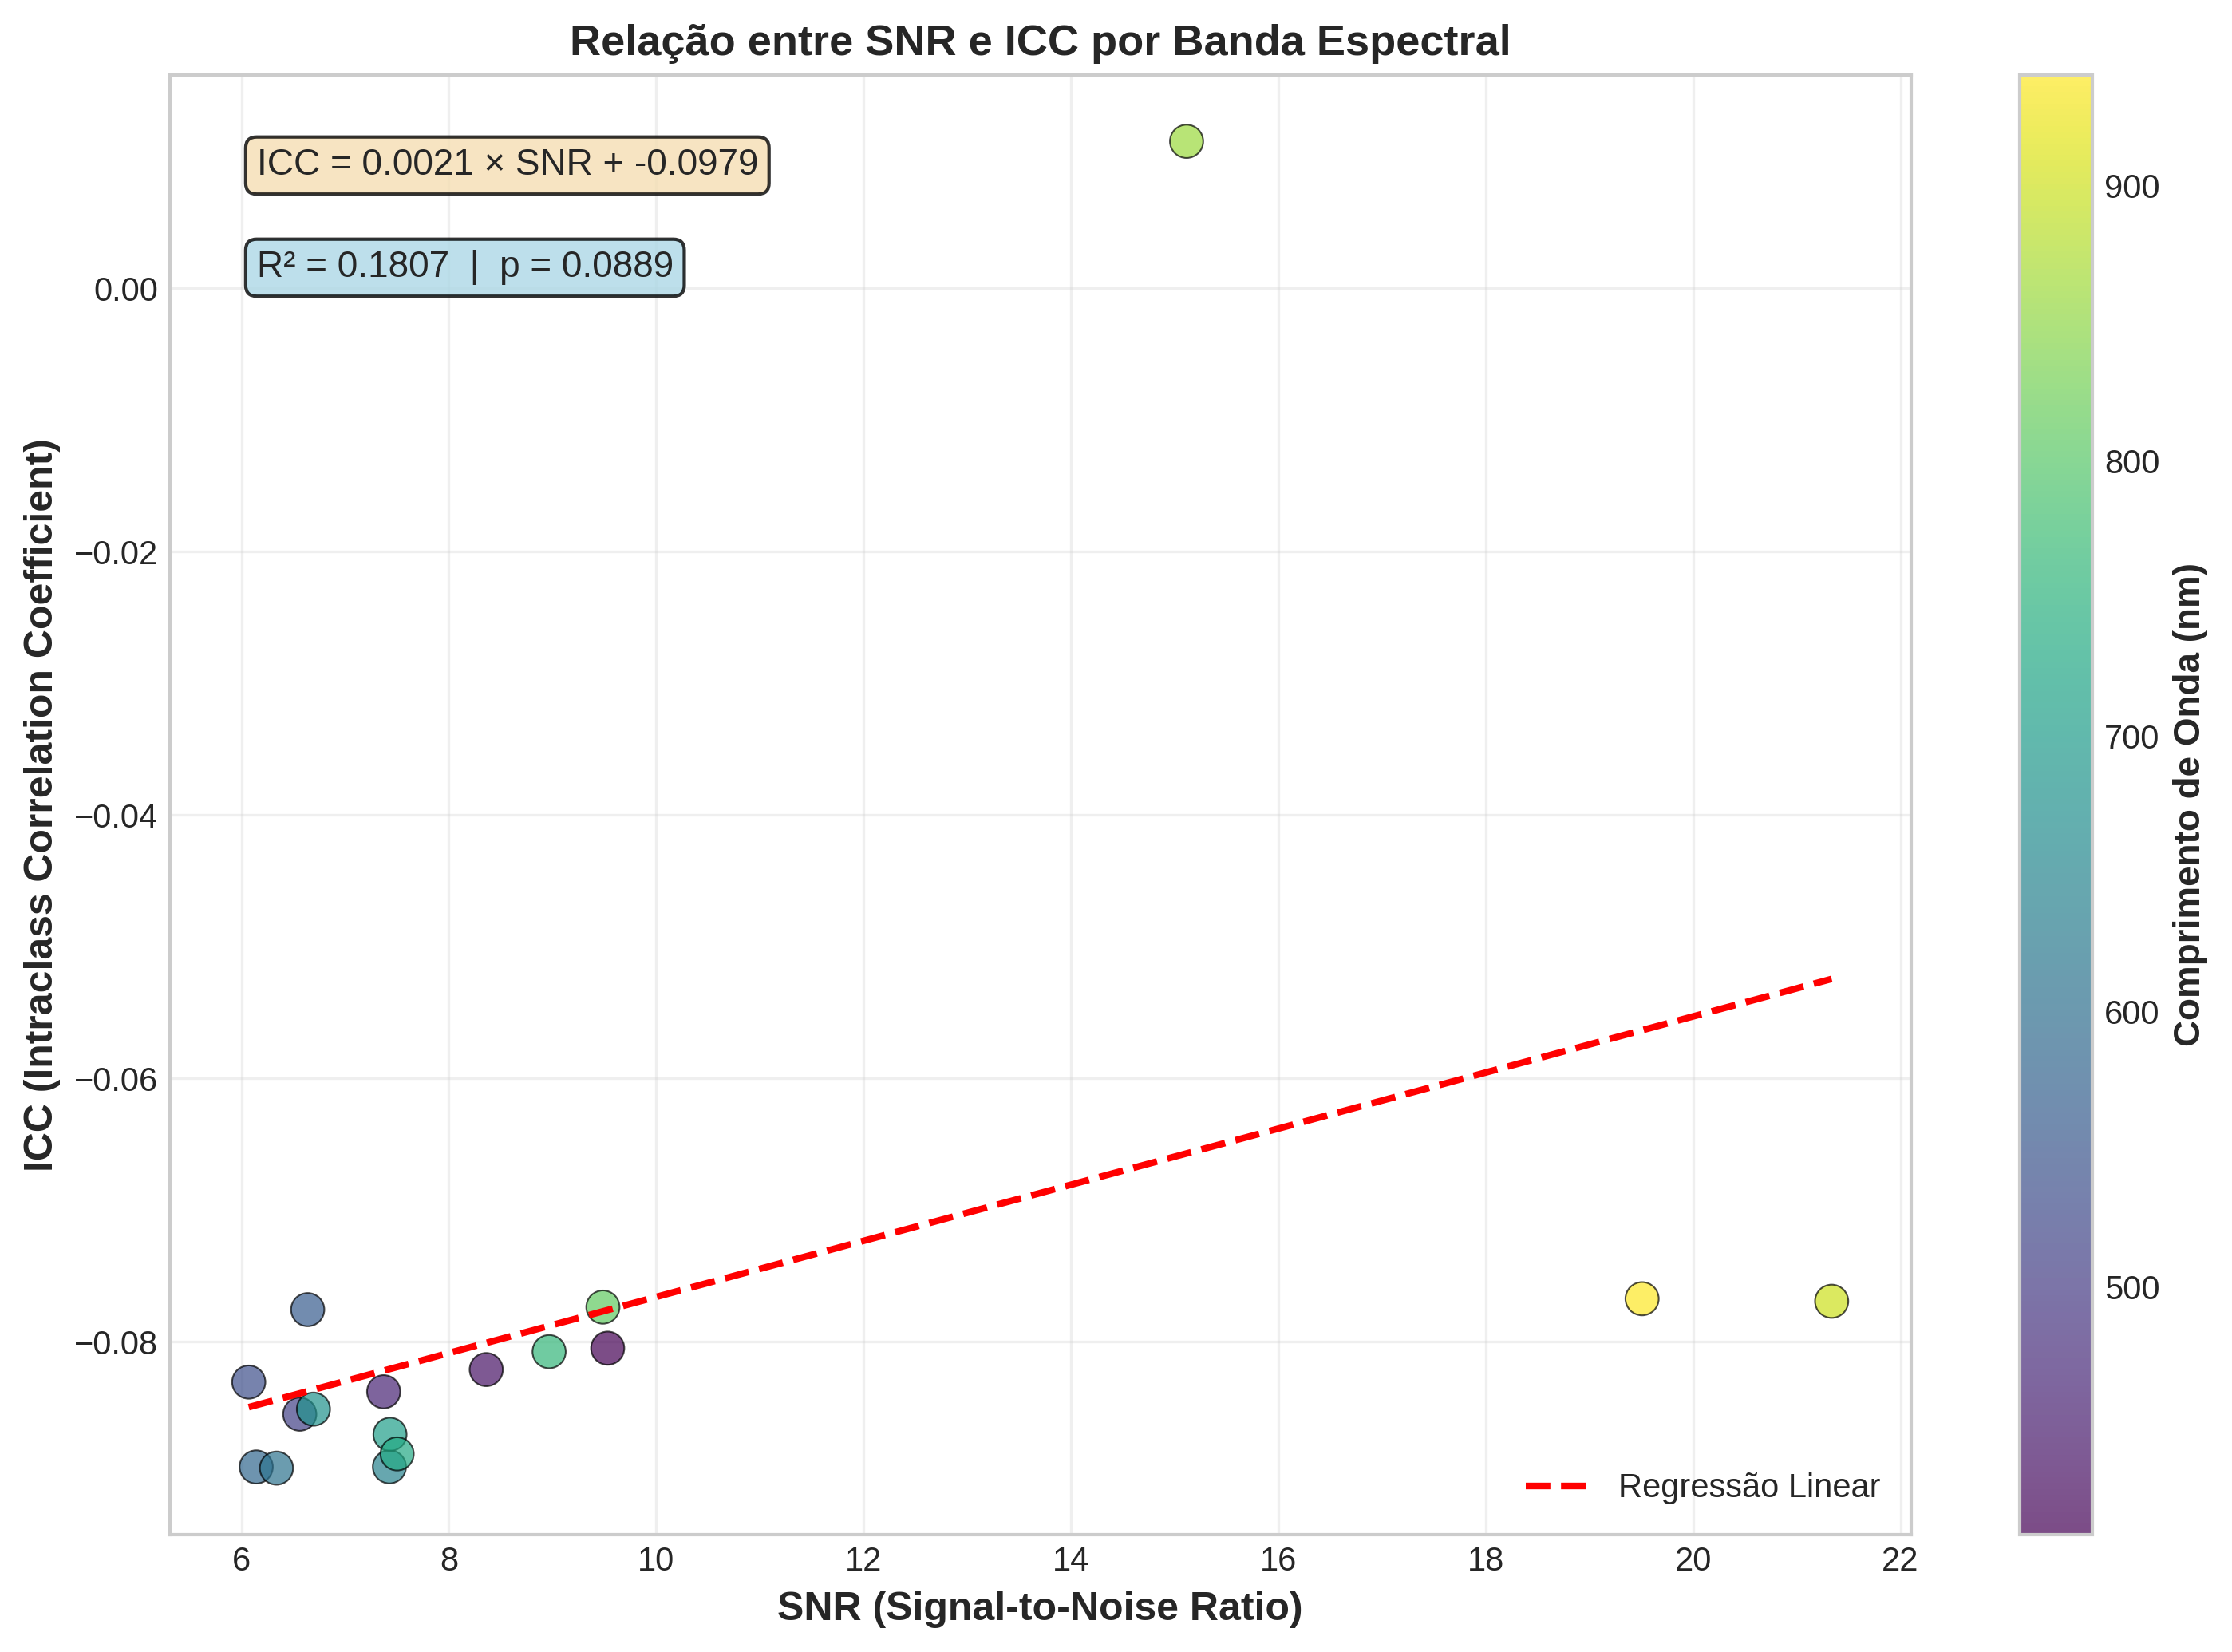

✅ Salvo: regressao_ICC_vs_SNR.png

4️⃣ Regressão: PC1 vs I4_Slope_Alt...


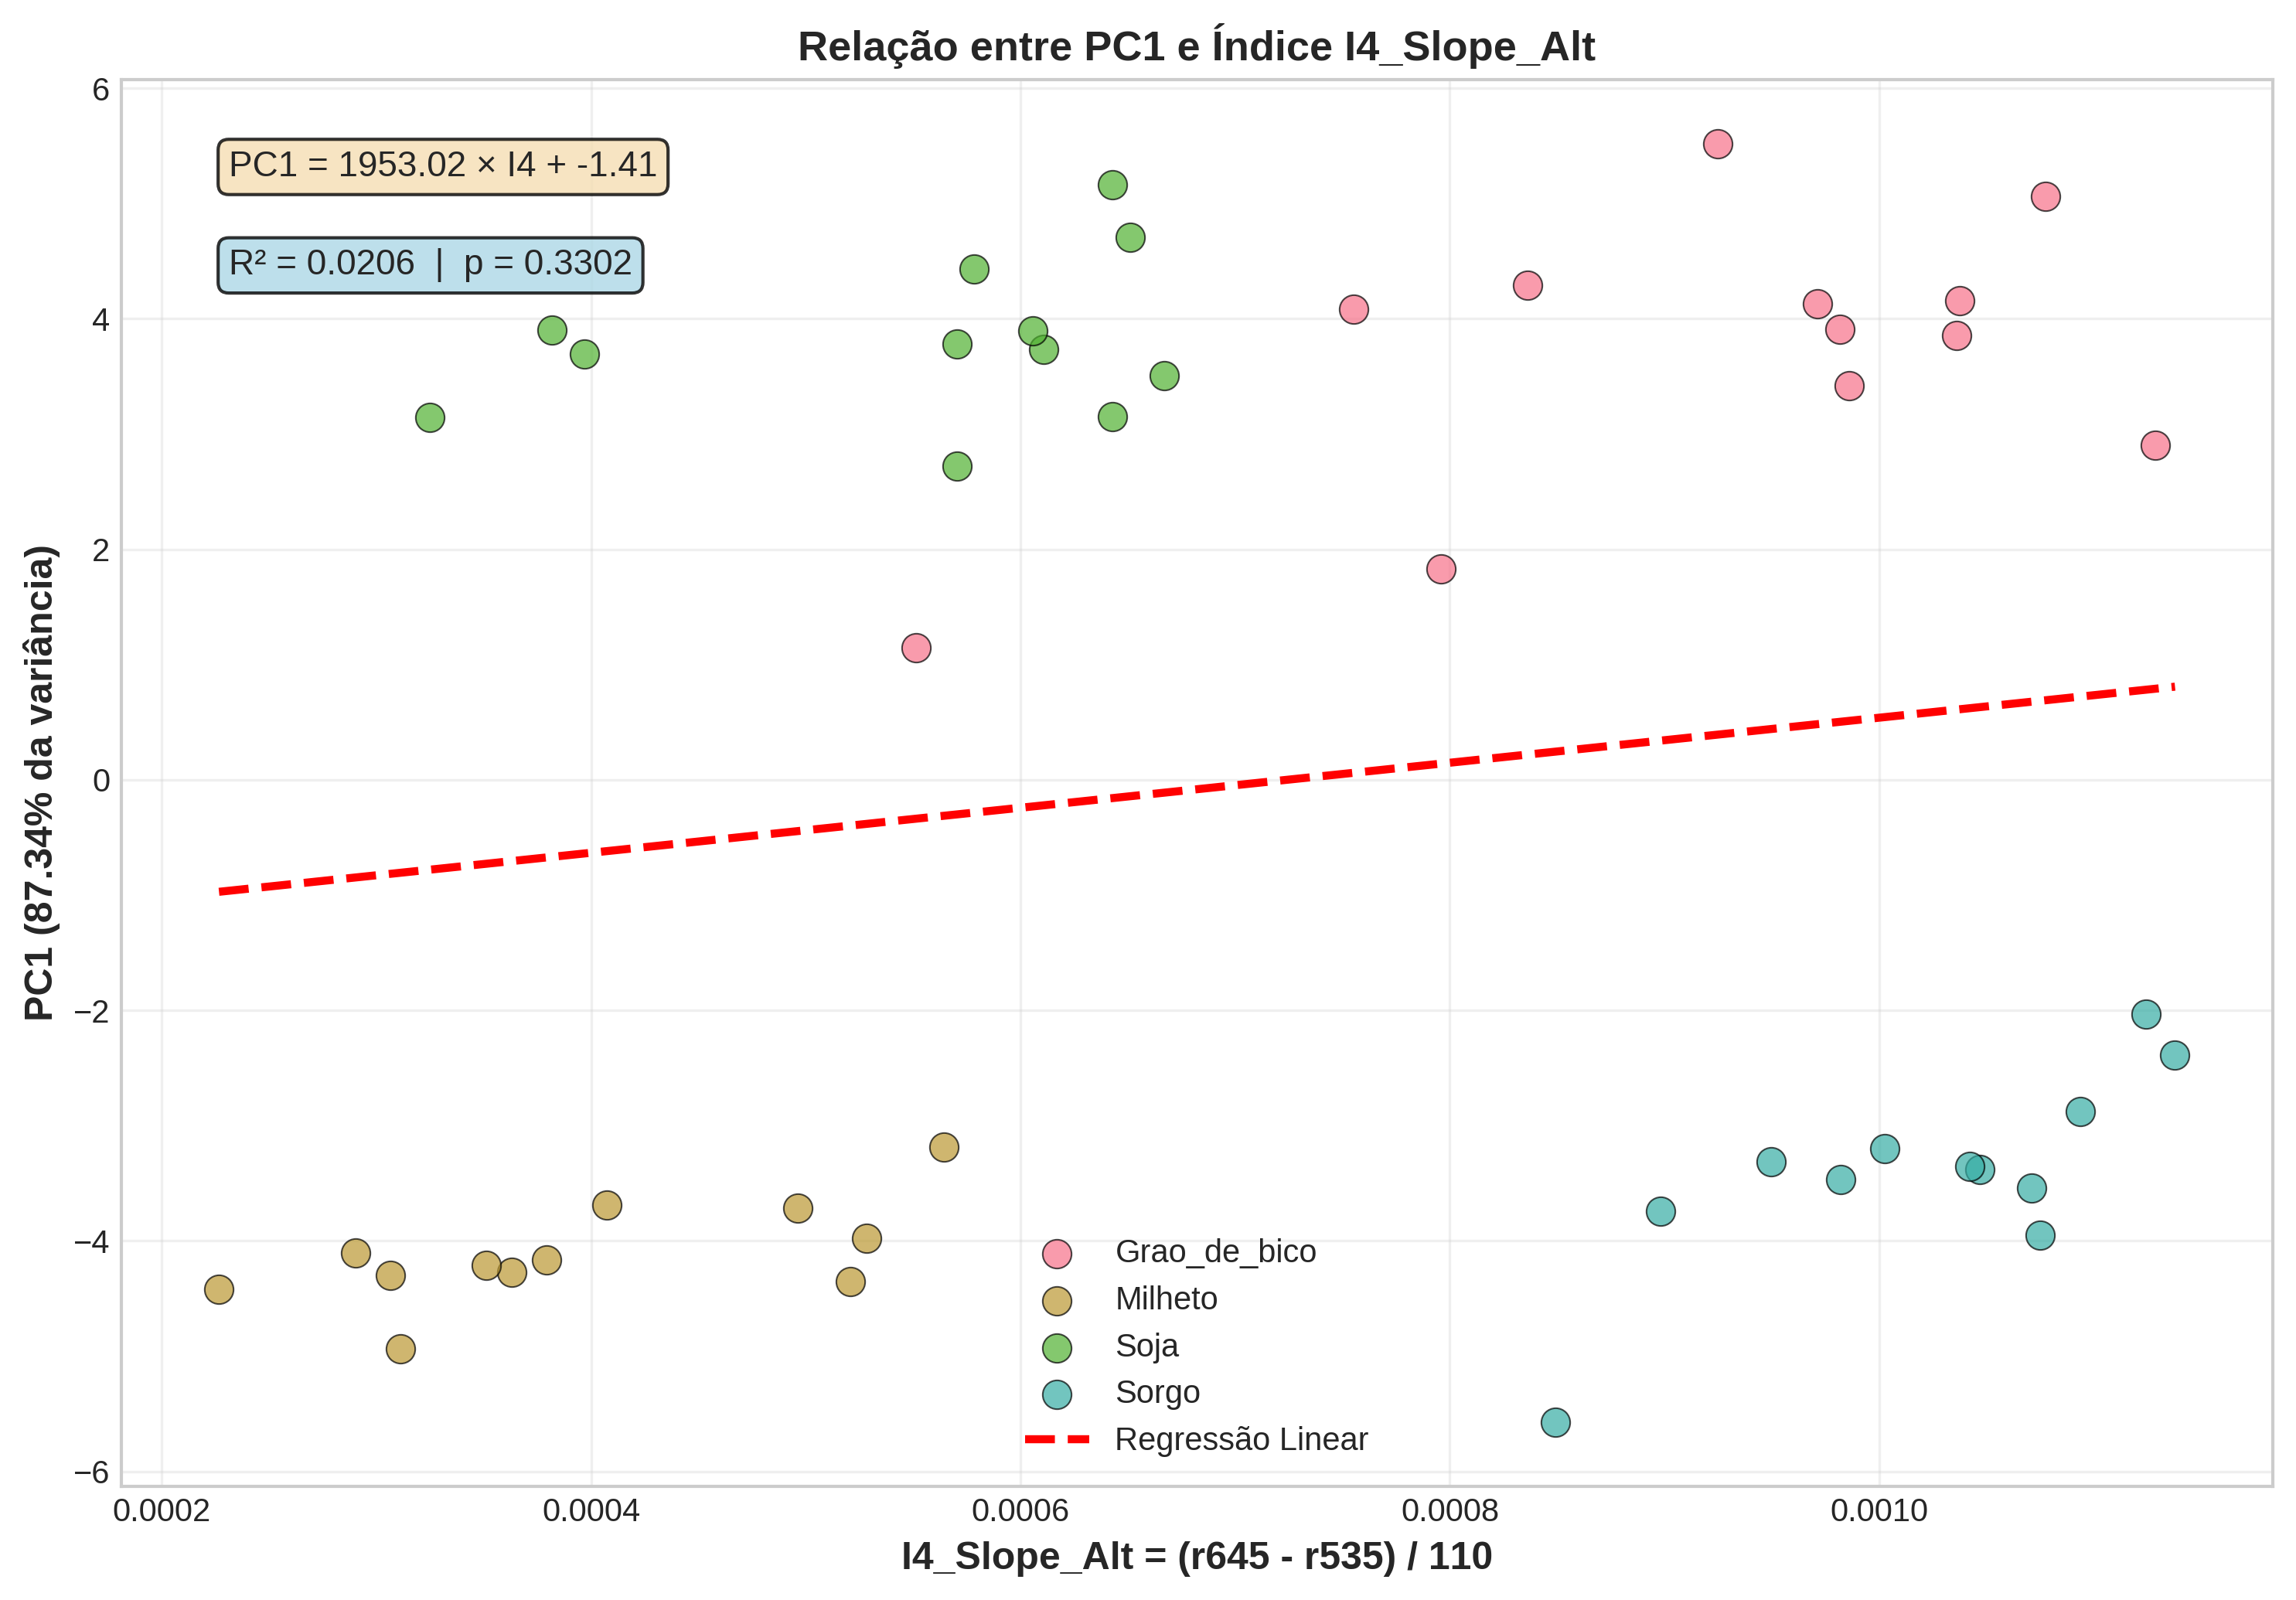

✅ Salvo: regressao_PC1_vs_I4_Slope_Alt.png

5️⃣ Heatmap: Correlação entre bandas...


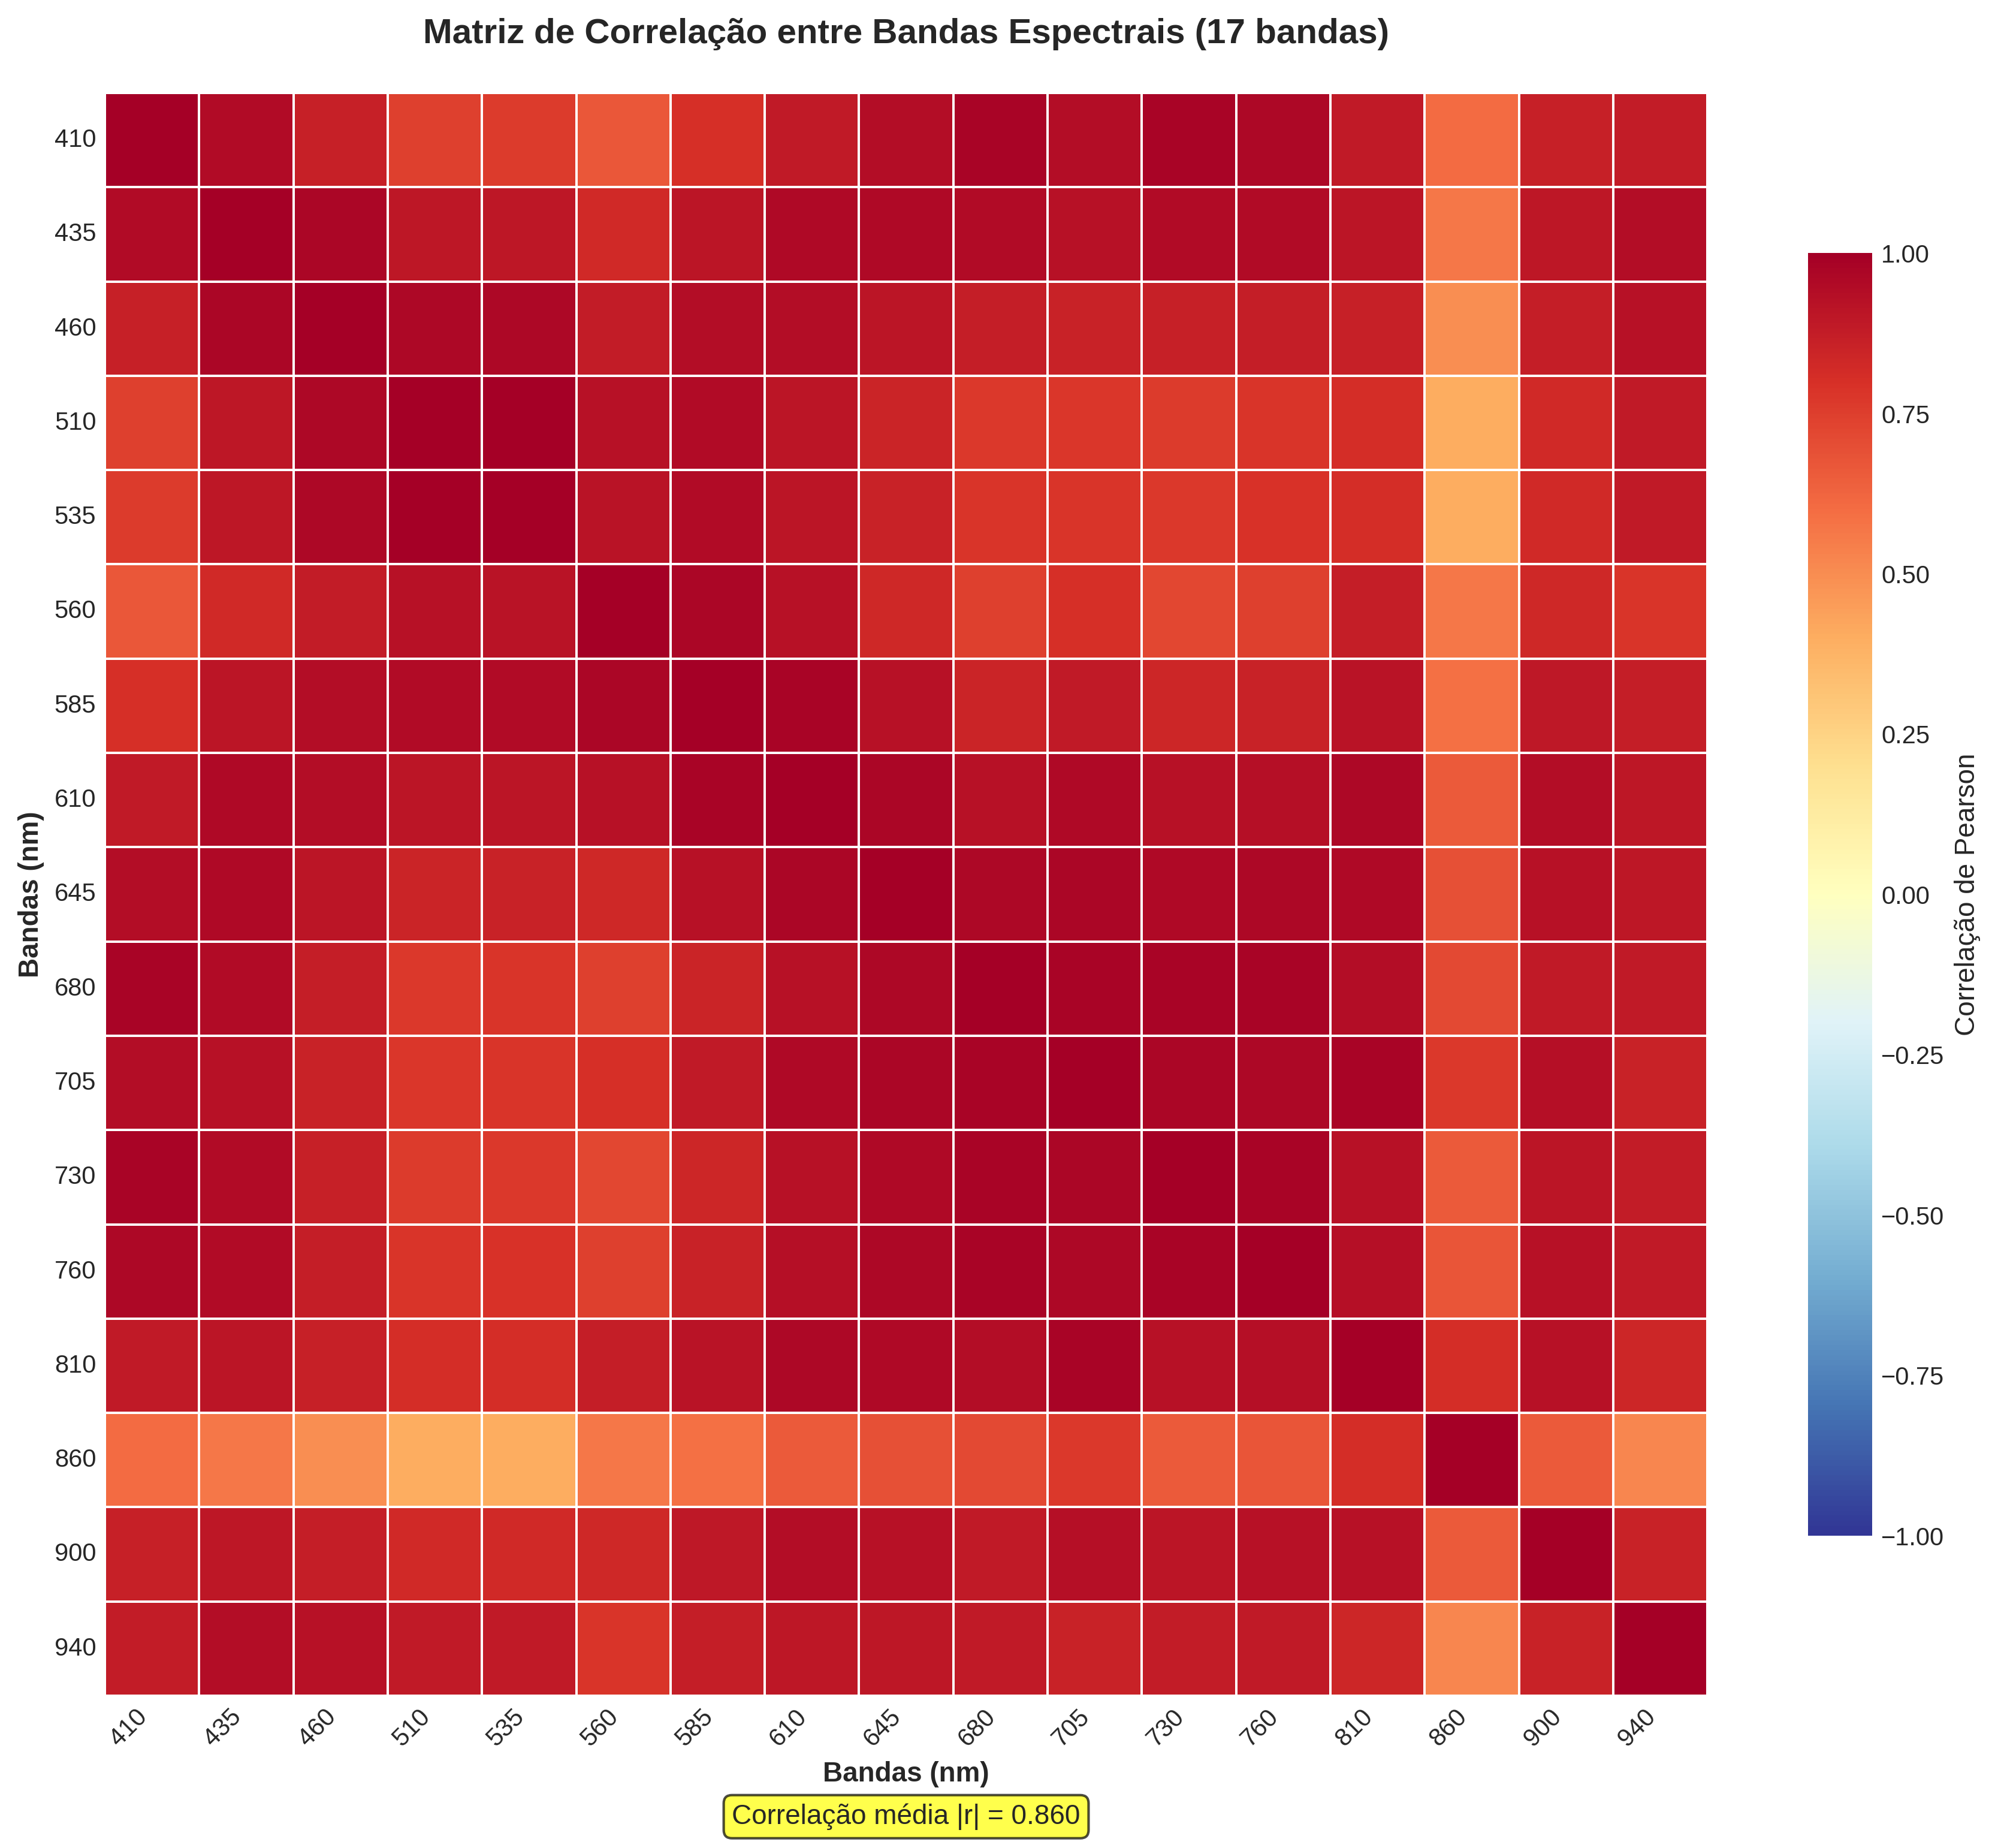

✅ Salvo: heatmap_correlacao_bandas.png

6️⃣ Boxplots: Índices espectrais por grão...


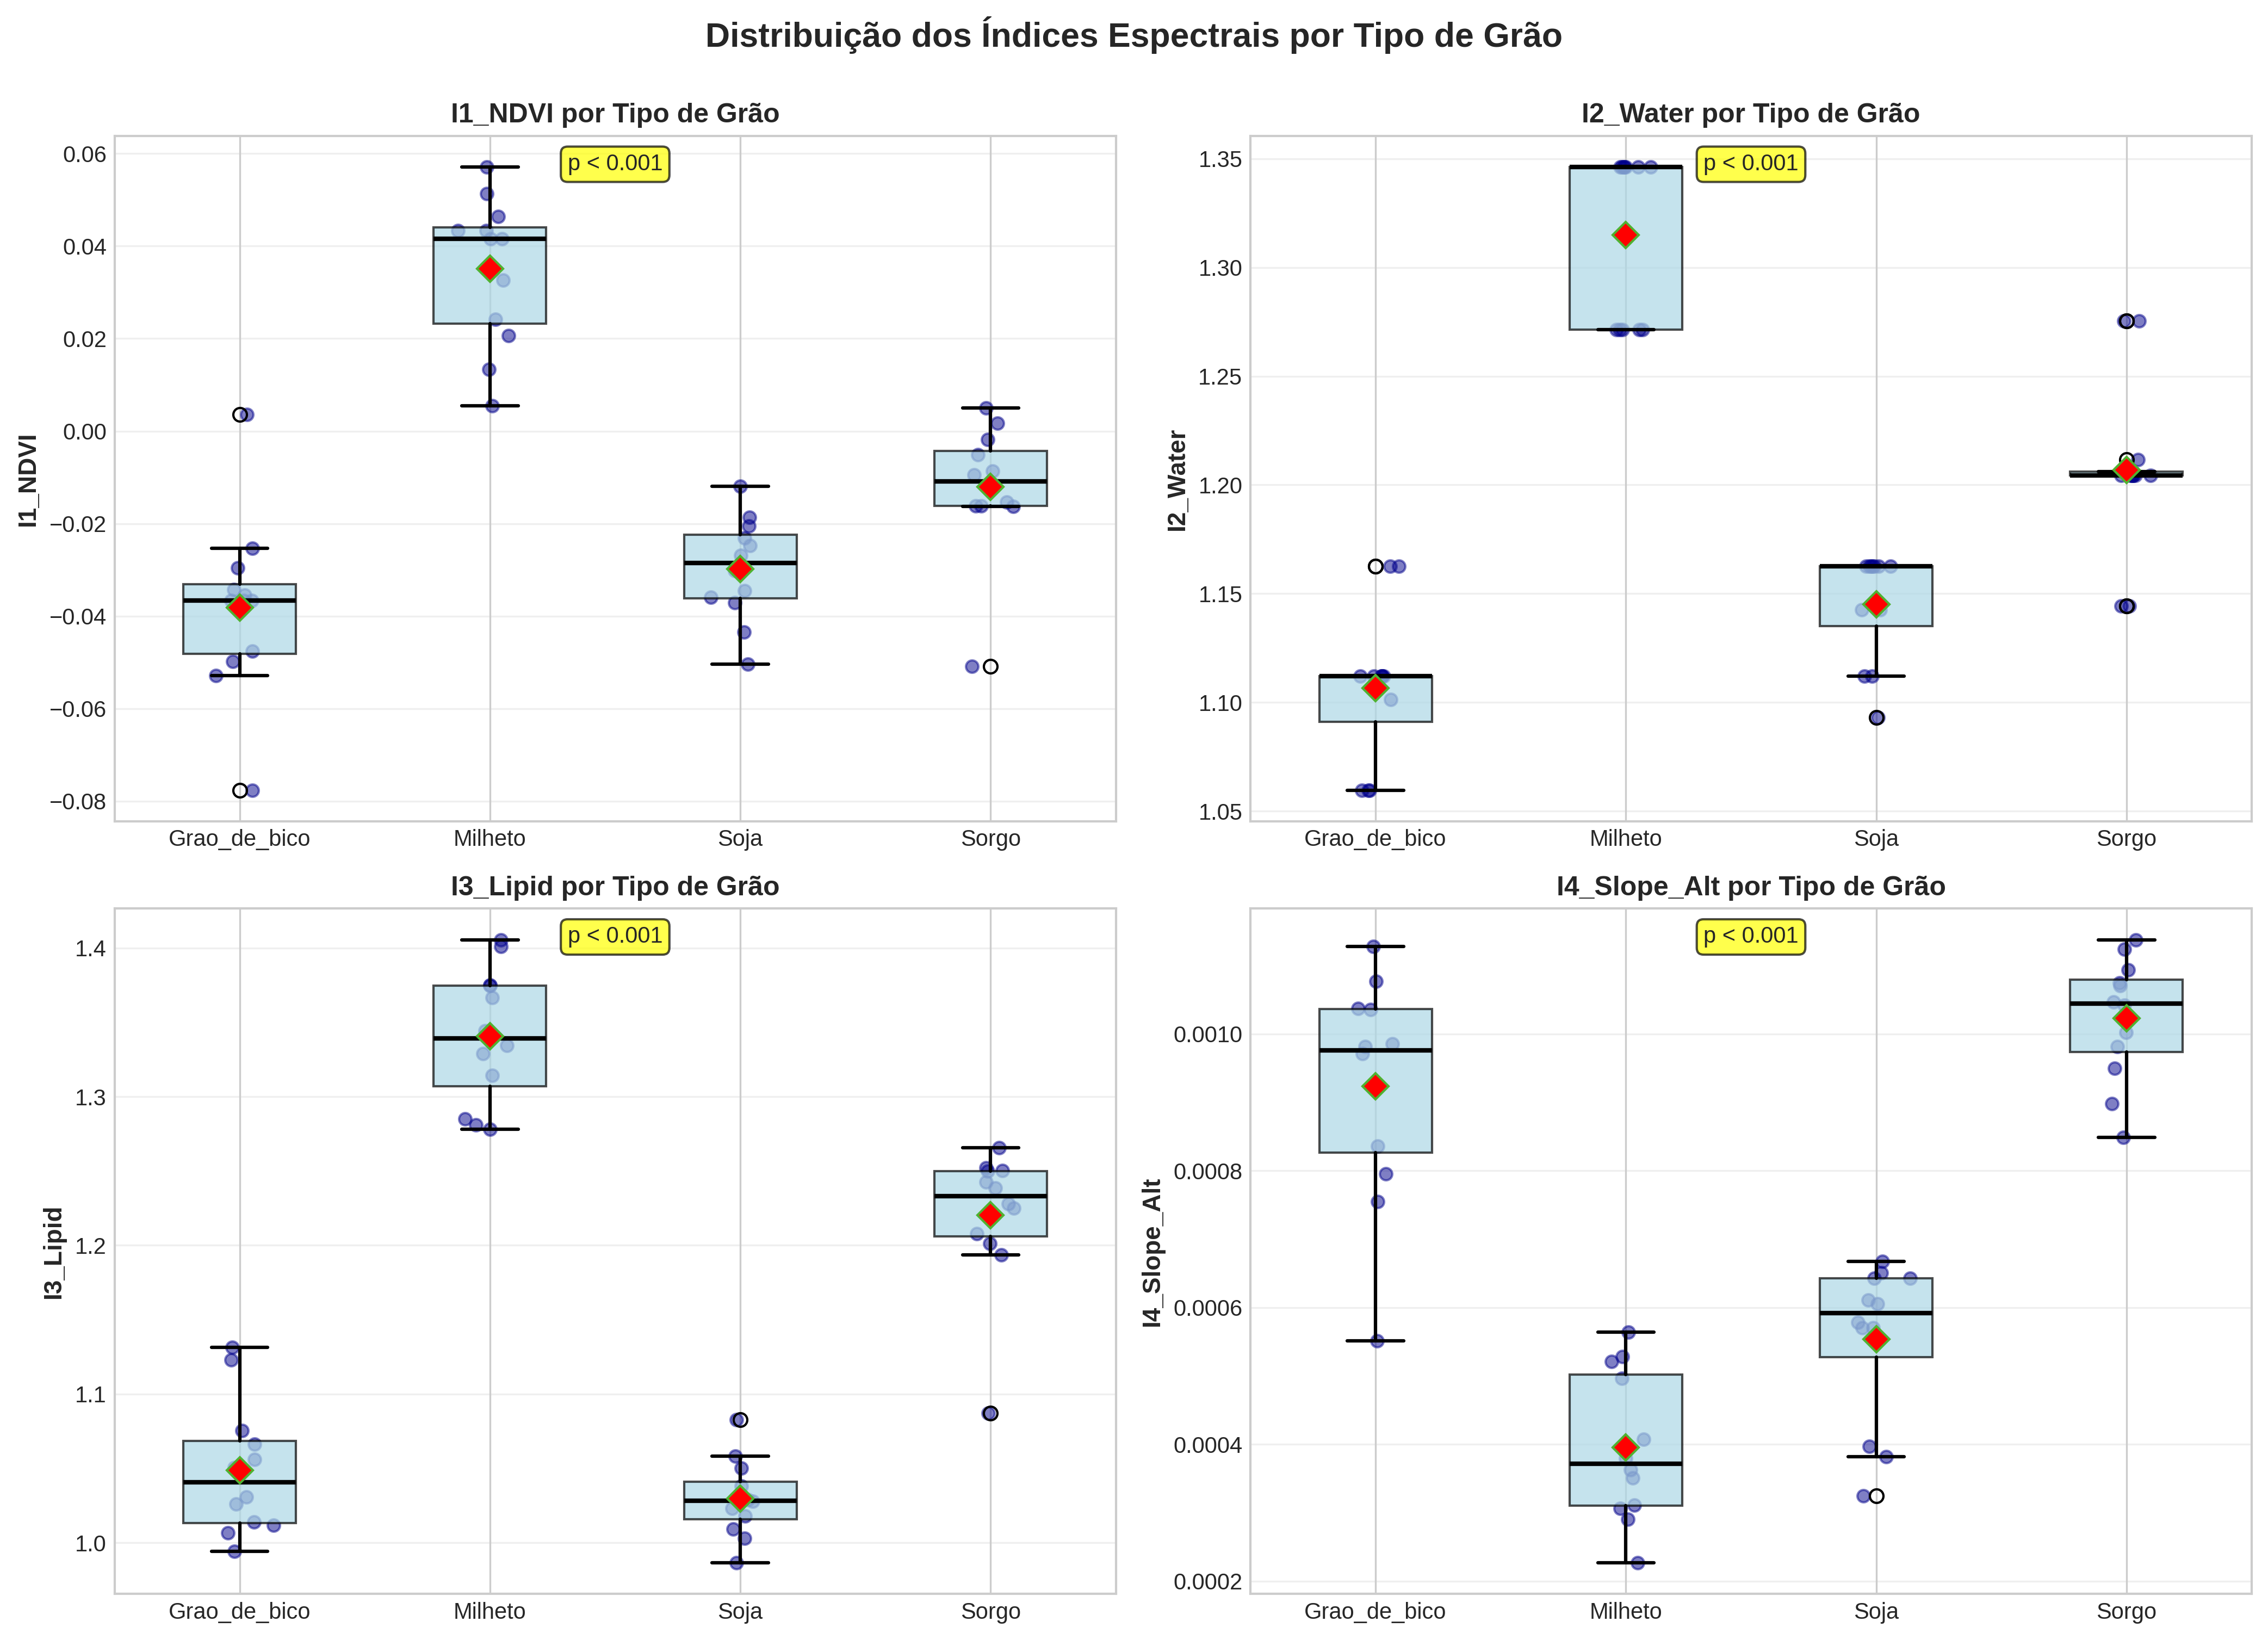

✅ Salvo: boxplots_indices_por_grao.png

7️⃣ Boxplots: Bandas espectrais selecionadas por grão...


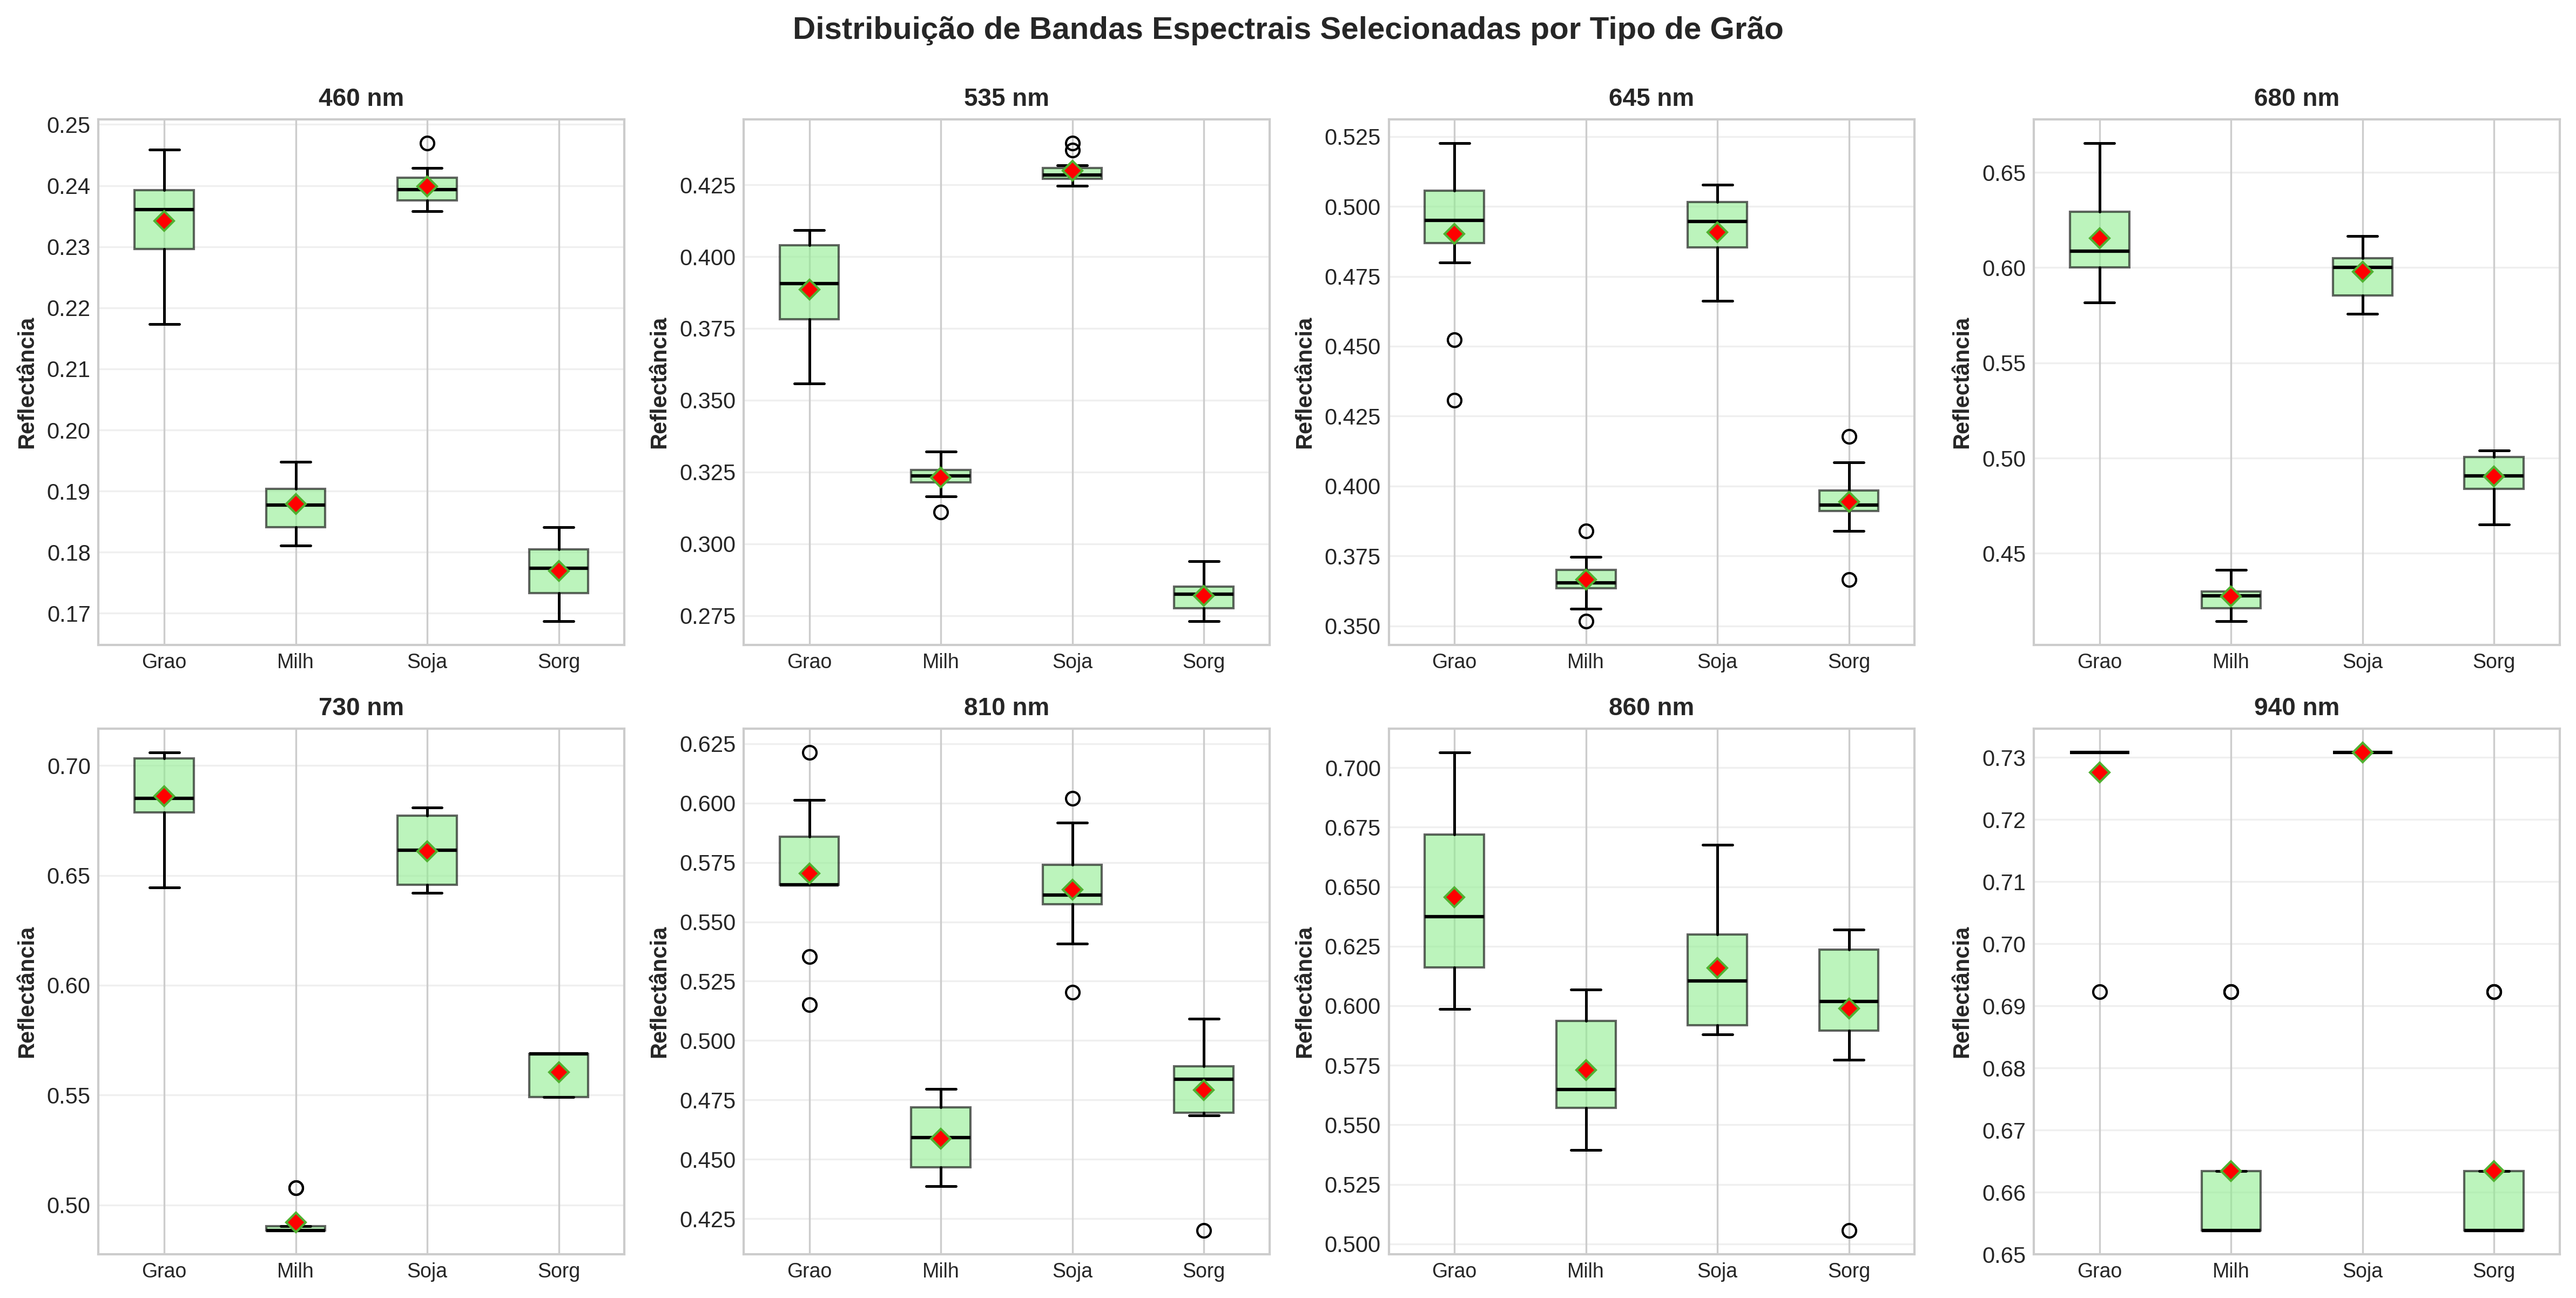

✅ Salvo: boxplots_bandas_selecionadas_por_grao.png

8️⃣ Gráfico de barras: Variância explicada PCA...


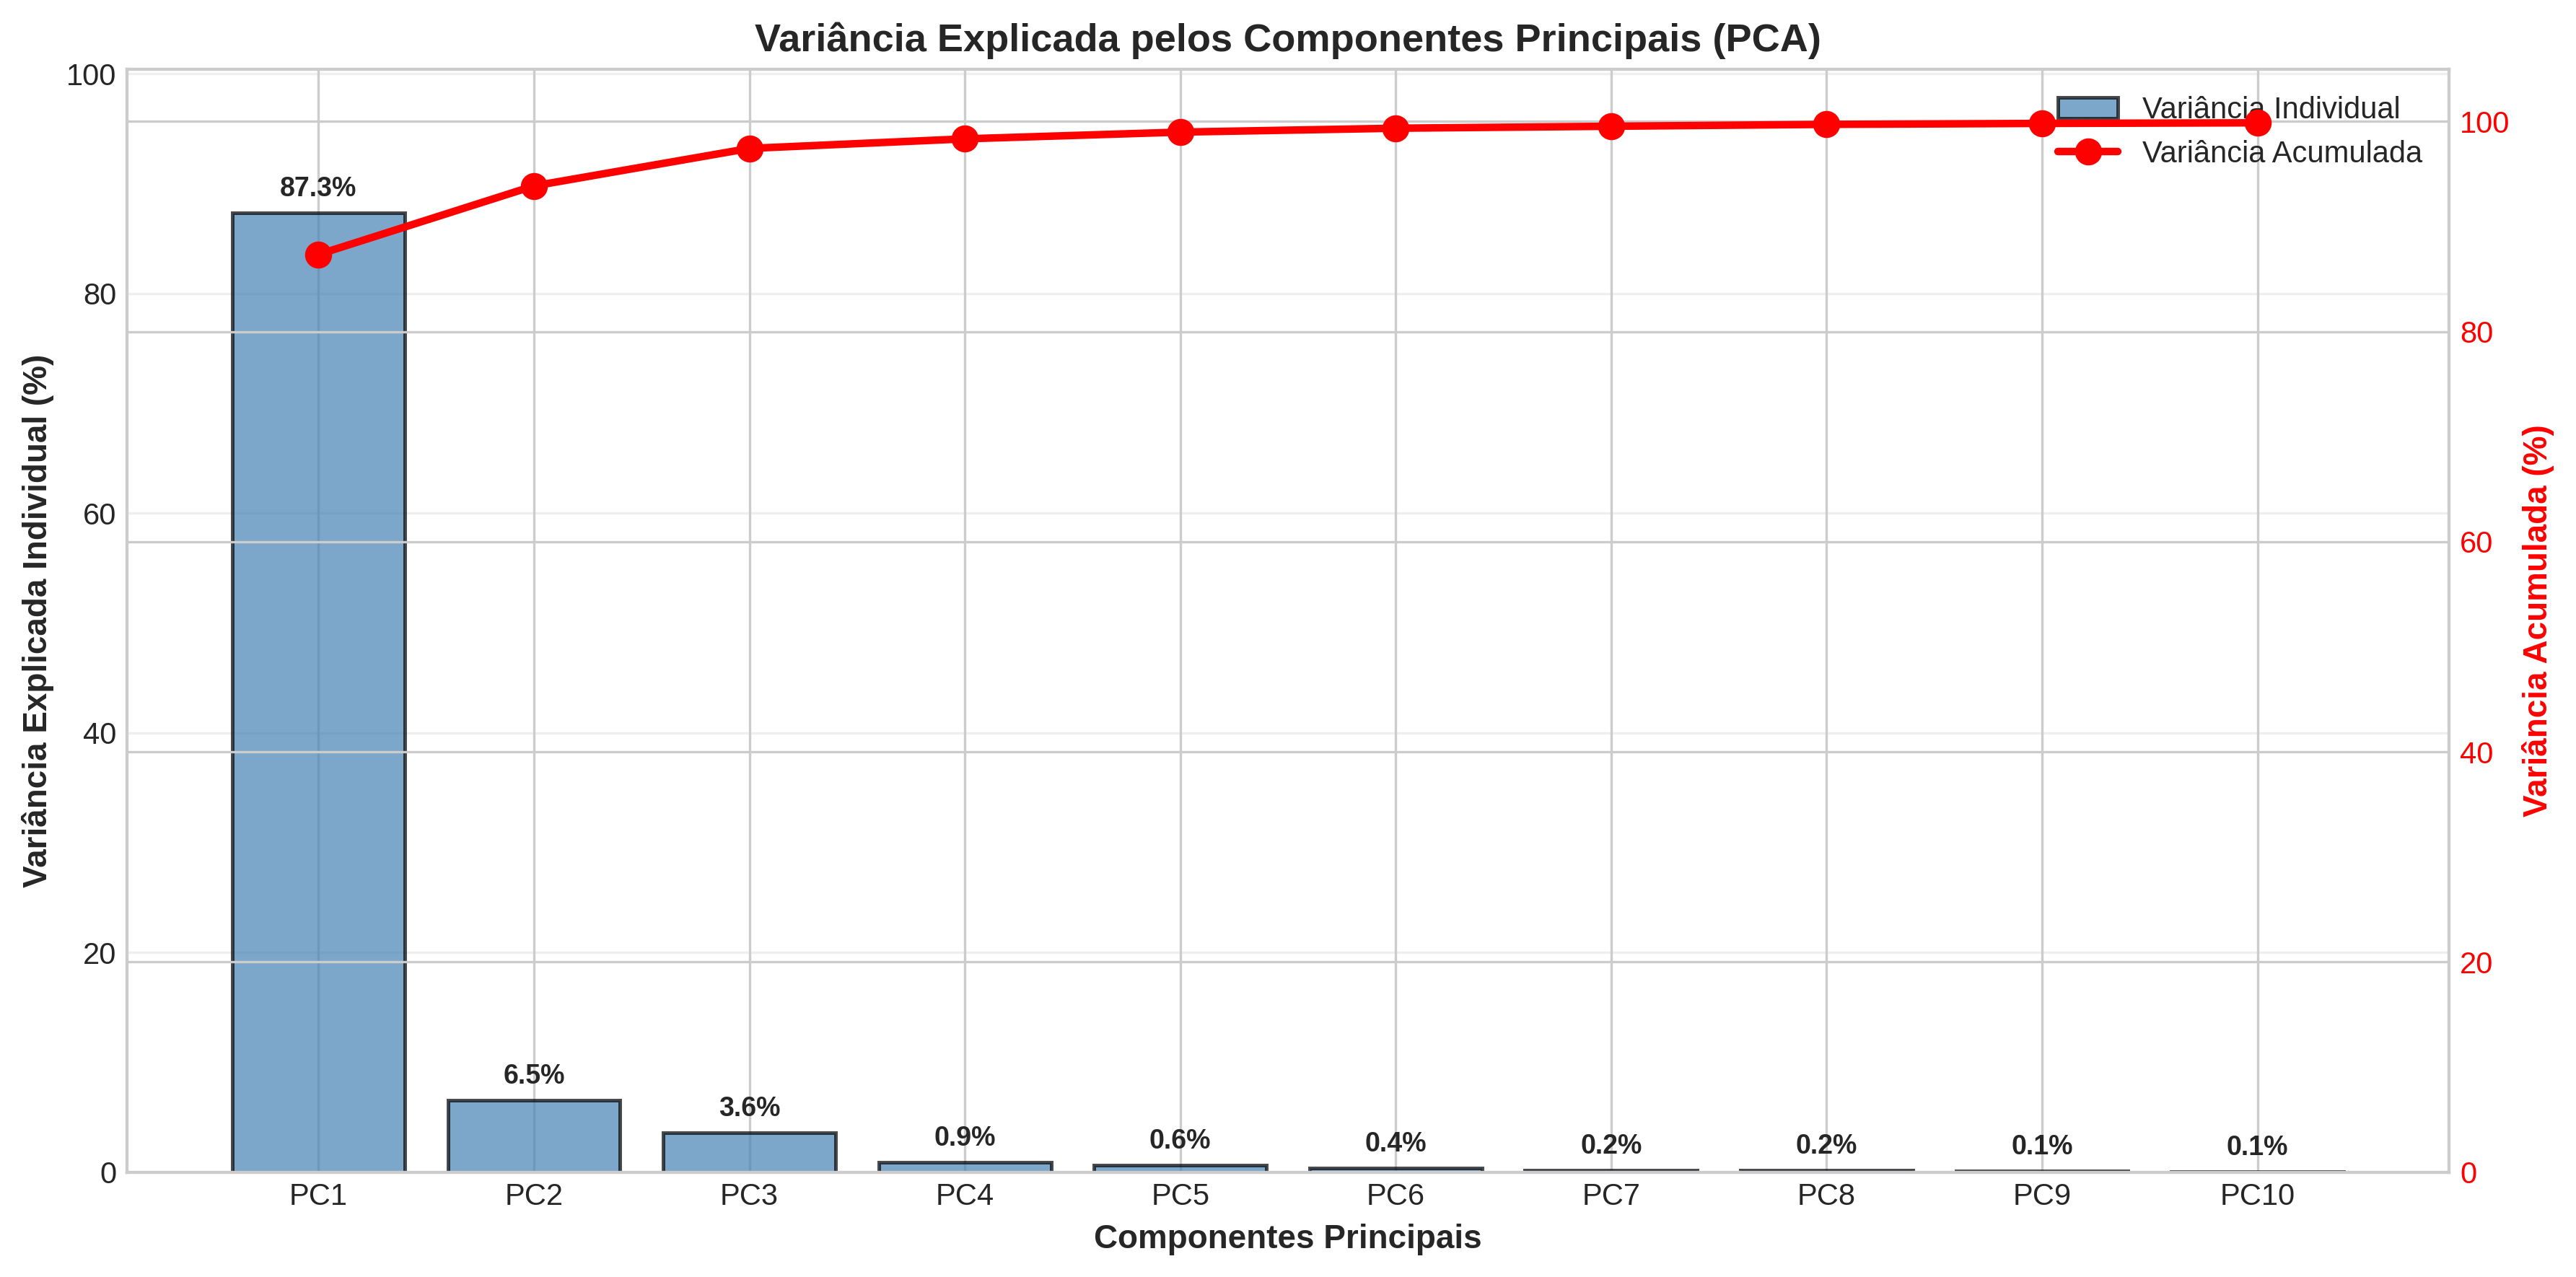

✅ Salvo: pca_variancia_explicada.png

9️⃣ Matriz de confusão do modelo final...


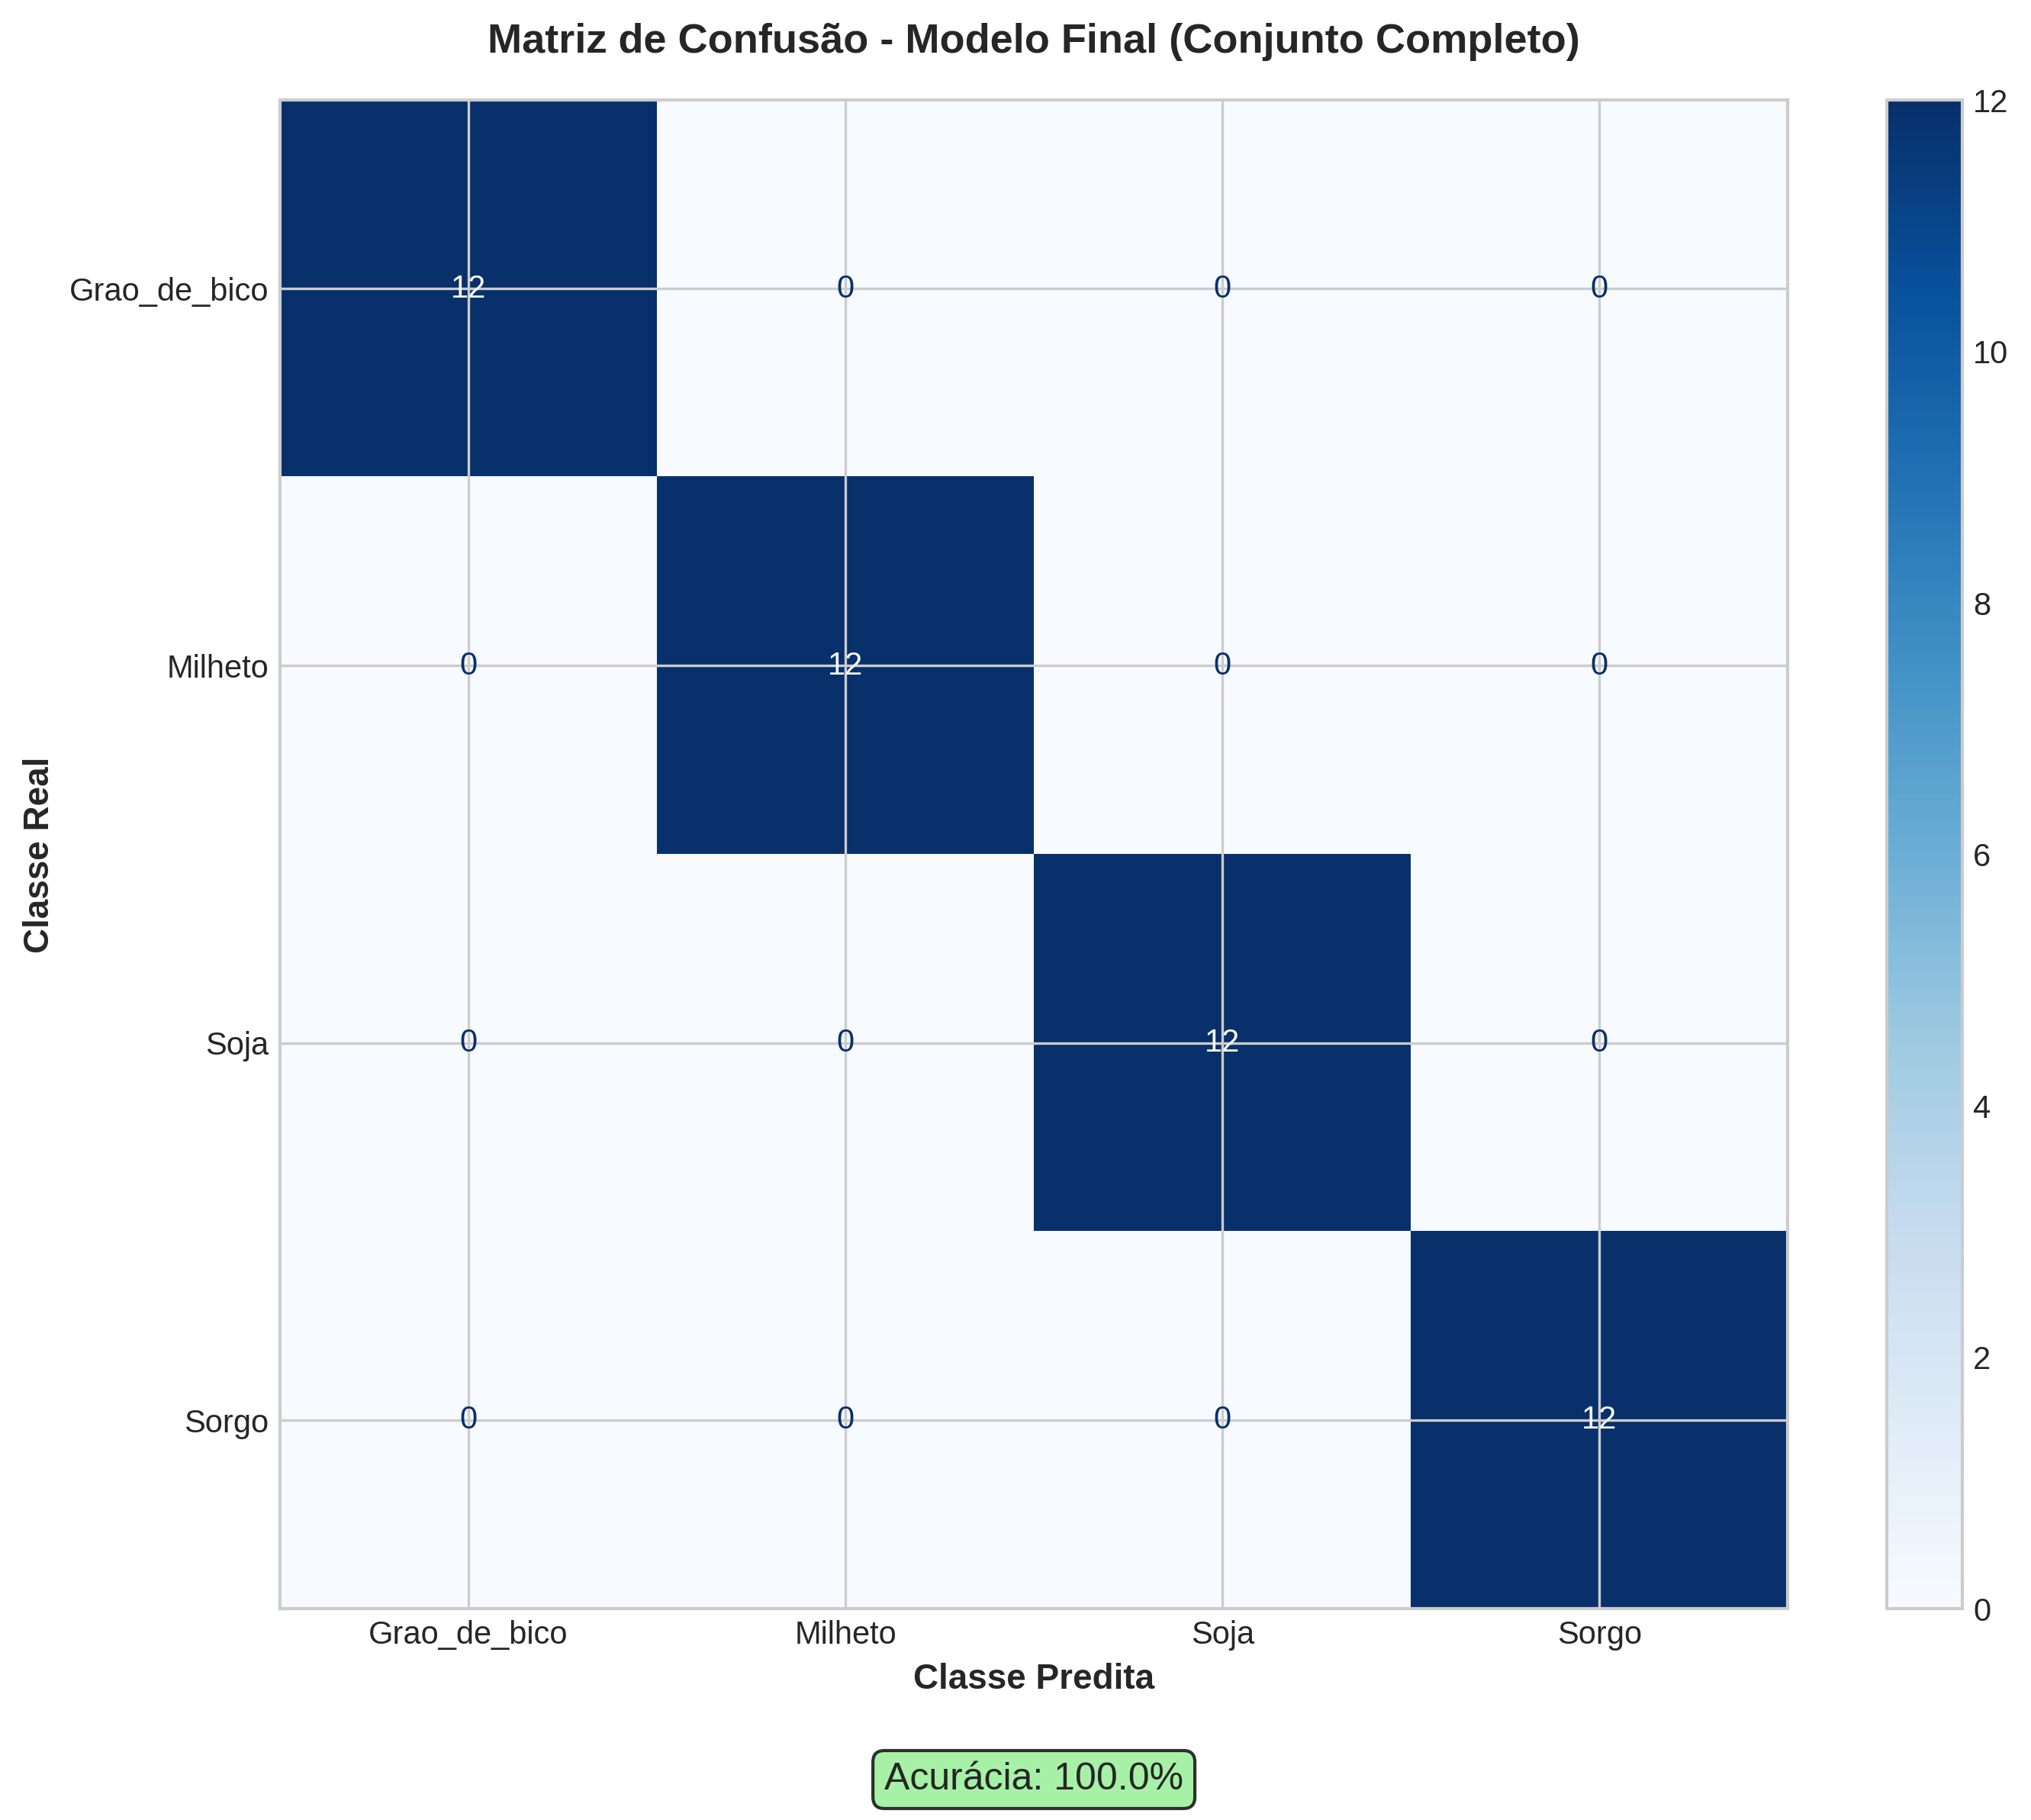

✅ Salvo: matriz_confusao_modelo_final.png

🔟 Gráfico: Métricas por fold (LOSO)...


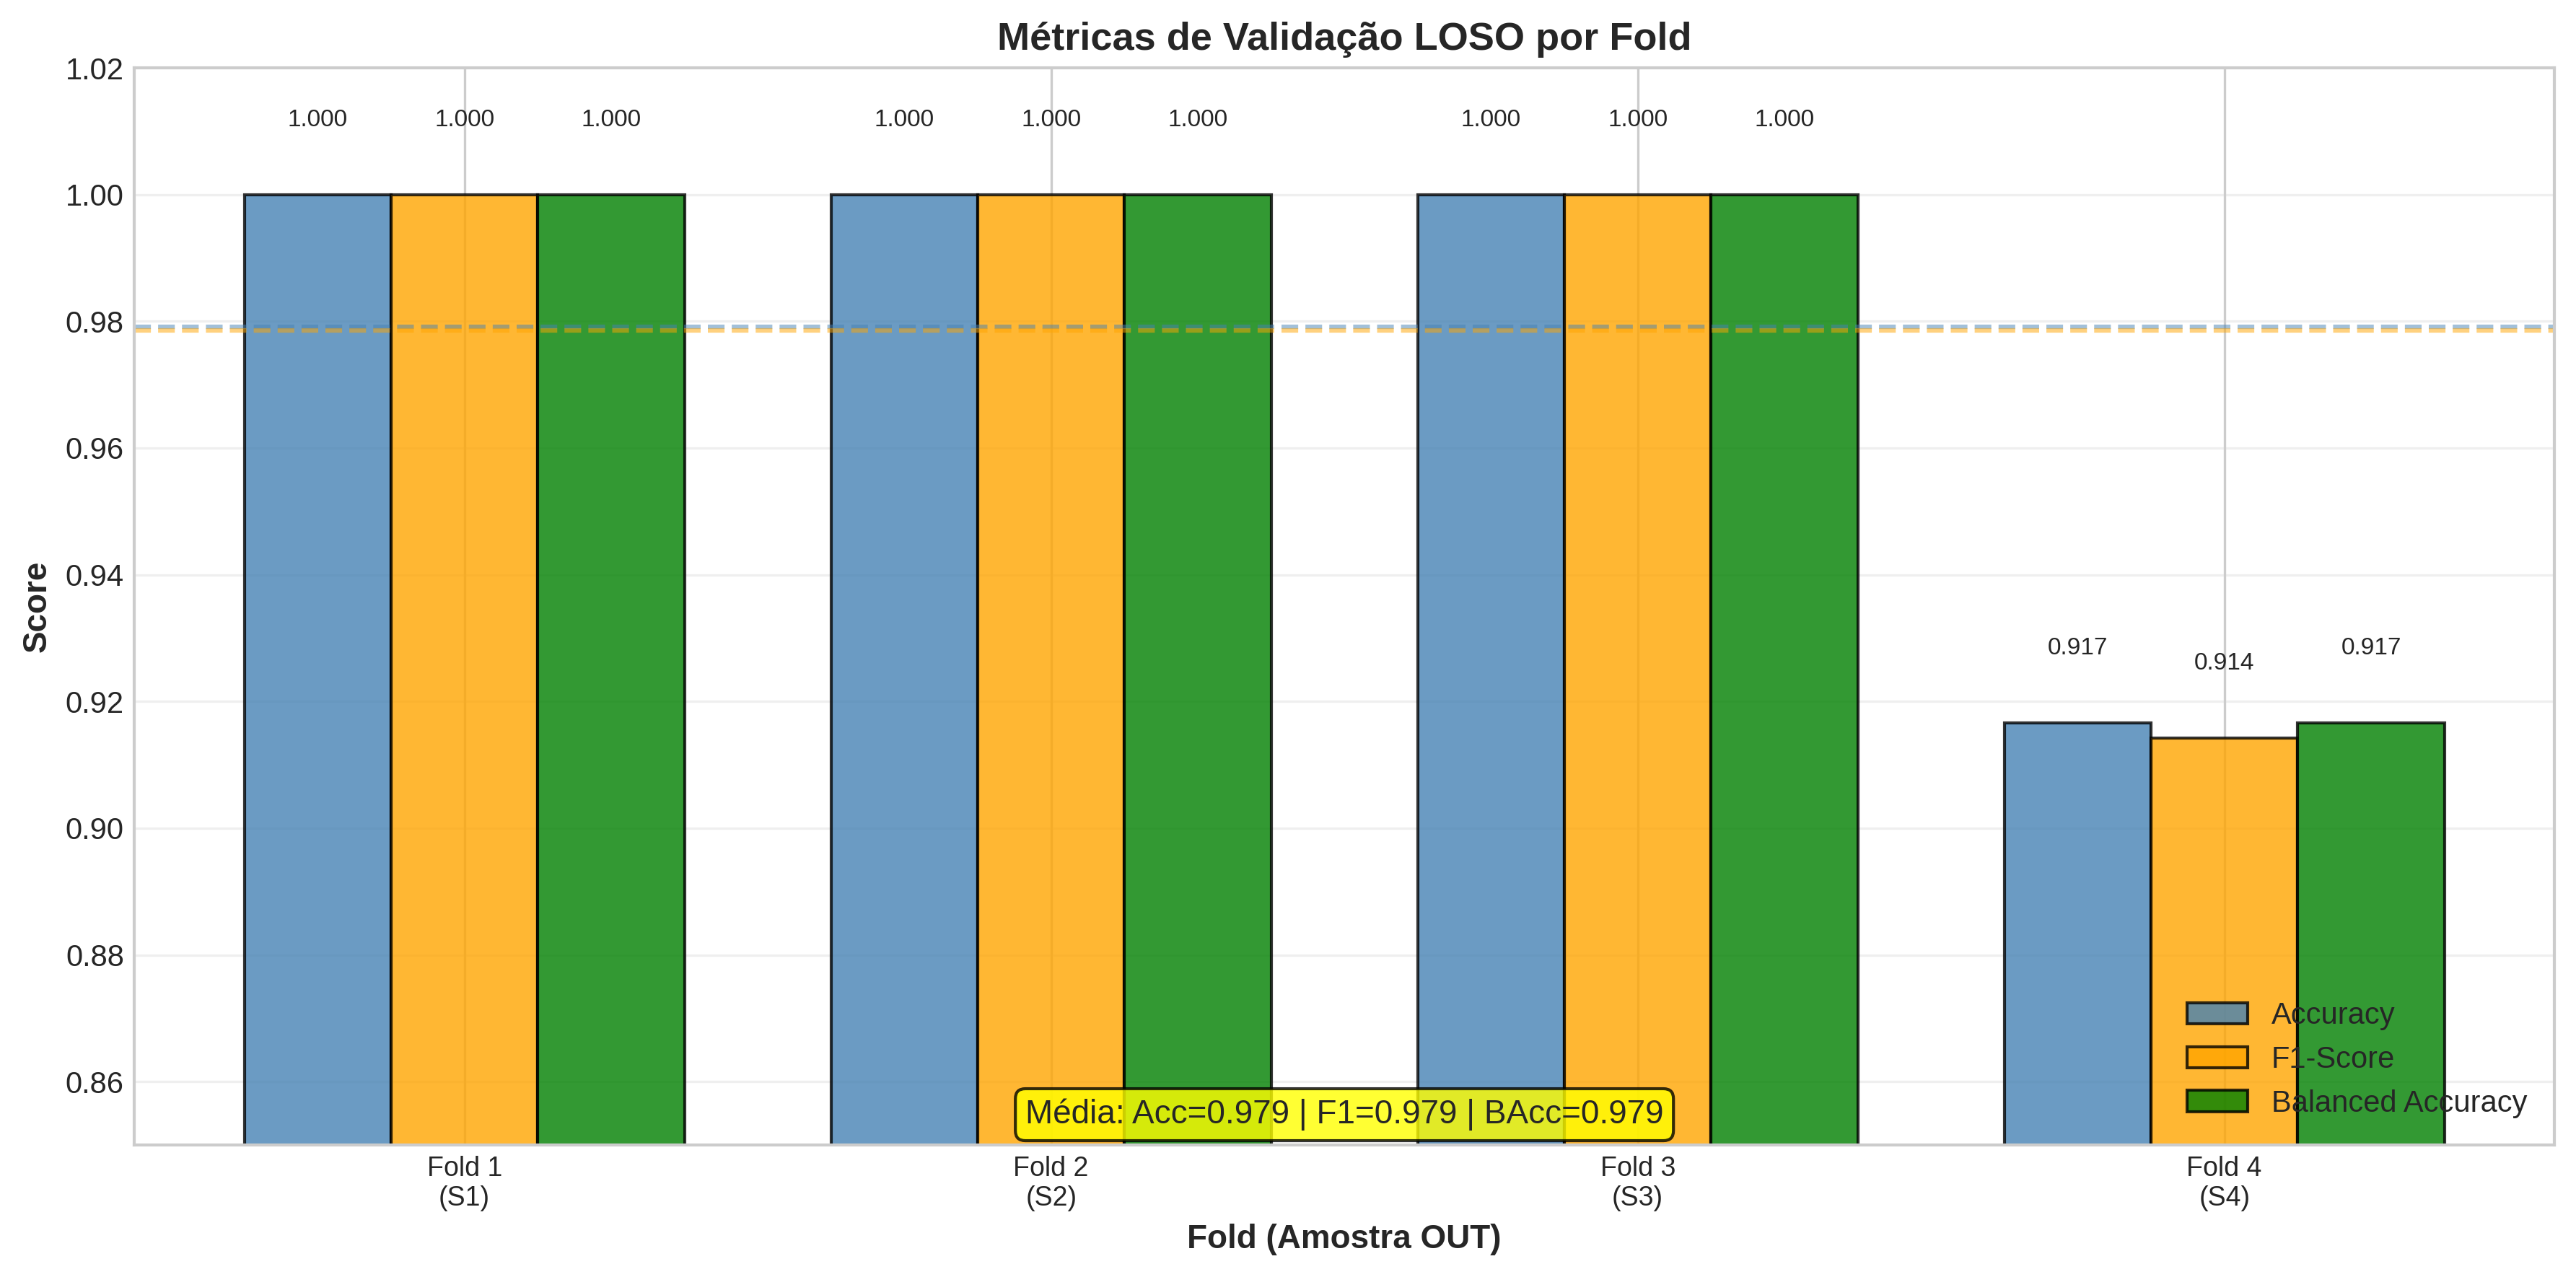

✅ Salvo: metricas_loso_por_fold.png

✅ TODOS OS GRÁFICOS GERADOS COM SUCESSO!

📁 Arquivos PNG salvos (300 DPI):
  1. metricas_ICC_CV_SNR_linhas.png
  2. assinaturas_espectrais_por_grao.png
  3. regressao_ICC_vs_SNR.png
  4. regressao_PC1_vs_I4_Slope_Alt.png
  5. heatmap_correlacao_bandas.png
  6. boxplots_indices_por_grao.png
  7. boxplots_bandas_selecionadas_por_grao.png
  8. pca_variancia_explicada.png
  9. matriz_confusao_modelo_final.png
 10. metricas_loso_por_fold.png
 11. pca_scores_pc1_pc2.png (já gerado anteriormente)

🎨 Total: 11 figuras profissionais para o artigo!


In [20]:
## 19. 📈 GRÁFICOS PROFISSIONAIS (300 DPI)

print("\n📈 GERANDO GRÁFICOS PROFISSIONAIS")
print("="*80)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import linregress

# Configuração para alta qualidade
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9

# ============================================================================
# 1. GRÁFICO DE LINHAS: ICC, CV%, SNR POR BANDA + TIPO DE GRÃO
# ============================================================================
print("\n1️⃣ Gráfico de linhas: ICC, CV%, SNR por banda...")

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

wavelengths = df_metricas['Wavelength_nm'].values

# Subplot 1: ICC
axes[0].plot(wavelengths, df_metricas['ICC'].values,
             marker='o', linewidth=2, markersize=6, color='#2E86AB', label='ICC')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='ICC=0')
axes[0].axhline(y=0.75, color='green', linestyle='--', linewidth=1, alpha=0.5, label='ICC=0.75 (excelente)')
axes[0].set_ylabel('ICC', fontweight='bold')
axes[0].set_title('Métricas de Confiabilidade por Banda Espectral (17 bandas, SEM 485nm)',
                  fontweight='bold', fontsize=13)
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='best')
axes[0].set_ylim([-0.5, 1.0])

# Subplot 2: CV%
axes[1].plot(wavelengths, df_metricas['CV_%'].values,
             marker='s', linewidth=2, markersize=6, color='#A23B72', label='CV%')
axes[1].axhline(y=20, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='CV%=20% (limite)')
axes[1].set_ylabel('CV (%)', fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='best')
axes[1].set_ylim([0, max(df_metricas['CV_%'].values) * 1.1])

# Subplot 3: SNR
axes[2].plot(wavelengths, df_metricas['SNR'].values,
             marker='^', linewidth=2, markersize=6, color='#F18F01', label='SNR')
axes[2].axhline(y=5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='SNR=5 (mínimo)')
axes[2].set_xlabel('Comprimento de Onda (nm)', fontweight='bold')
axes[2].set_ylabel('SNR', fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].legend(loc='best')
axes[2].set_ylim([0, max(df_metricas['SNR'].values) * 1.1])

# Adicionar resumo
textstr = f'Média: ICC={df_metricas["ICC"].mean():.3f} | CV%={df_metricas["CV_%"].mean():.2f}% | SNR={df_metricas["SNR"].mean():.2f}'
fig.text(0.5, 0.02, textstr, ha='center', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.savefig('metricas_ICC_CV_SNR_linhas.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Salvo: metricas_ICC_CV_SNR_linhas.png")

# ============================================================================
# 2. GRÁFICO DE LINHAS: ASSINATURAS ESPECTRAIS POR GRÃO (MÉDIA)
# ============================================================================
print("\n2️⃣ Assinaturas espectrais médias por tipo de grão...")

fig, ax = plt.subplots(figsize=(12, 7))

colors_grain = {'soja': '#2E86AB', 'milheto': '#A23B72',
                'sorgo': '#F18F01', 'grao_de_bico': '#06A77D'}

for grain in df_avg['grain'].unique():
    grain_data = df_avg[df_avg['grain'] == grain][bandas_r].mean().values
    ax.plot(wavelengths, grain_data, marker='o', linewidth=2.5,
            markersize=7, label=grain.capitalize(),
            color=colors_grain.get(grain, 'gray'), alpha=0.85)

ax.set_xlabel('Comprimento de Onda (nm)', fontweight='bold', fontsize=12)
ax.set_ylabel('Reflectância Média', fontweight='bold', fontsize=12)
ax.set_title('Assinaturas Espectrais Médias por Tipo de Grão (17 bandas)',
             fontweight='bold', fontsize=14)
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)

# Destacar bandas NIR
ax.axvspan(760, 940, alpha=0.1, color='red', label='NIR')
ax.text(850, ax.get_ylim()[1]*0.95, 'NIR', fontsize=10,
        ha='center', color='red', fontweight='bold')

plt.tight_layout()
plt.savefig('assinaturas_espectrais_por_grao.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Salvo: assinaturas_espectrais_por_grao.png")

# ============================================================================
# 3. REGRESSÃO: ICC vs SNR com equação
# ============================================================================
print("\n3️⃣ Regressão: ICC vs SNR...")

fig, ax = plt.subplots(figsize=(10, 7))

x = df_metricas['SNR'].values
y = df_metricas['ICC'].values

# Calcular regressão linear
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Scatter plot
scatter = ax.scatter(x, y, c=df_metricas['Wavelength_nm'],
                     cmap='viridis', s=100, alpha=0.7, edgecolors='k', linewidth=0.5)

# Linha de regressão
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = slope * x_fit + intercept
ax.plot(x_fit, y_fit, 'r--', linewidth=2, label='Regressão Linear')

# Equação e R²
equation = f'ICC = {slope:.4f} × SNR + {intercept:.4f}'
r2_text = f'R² = {r_value**2:.4f}  |  p = {p_value:.4f}'
ax.text(0.05, 0.95, equation, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
ax.text(0.05, 0.88, r2_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

ax.set_xlabel('SNR (Signal-to-Noise Ratio)', fontweight='bold', fontsize=12)
ax.set_ylabel('ICC (Intraclass Correlation Coefficient)', fontweight='bold', fontsize=12)
ax.set_title('Relação entre SNR e ICC por Banda Espectral', fontweight='bold', fontsize=13)
ax.grid(True, alpha=0.3)
ax.legend(loc='lower right', fontsize=10)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Comprimento de Onda (nm)', fontweight='bold')

plt.tight_layout()
plt.savefig('regressao_ICC_vs_SNR.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Salvo: regressao_ICC_vs_SNR.png")

# ============================================================================
# 4. REGRESSÃO: PC1 vs I4_Slope_Alt com equação
# ============================================================================
print("\n4️⃣ Regressão: PC1 vs I4_Slope_Alt...")

fig, ax = plt.subplots(figsize=(10, 7))

x = df_indices['I4_Slope_Alt'].values
y = X_pca[:, 0]  # PC1
grains = df_indices['grain'].values

# Calcular regressão
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Scatter por grão
for grain in np.unique(grains):
    mask = grains == grain
    ax.scatter(x[mask], y[mask], label=grain.capitalize(),
               s=80, alpha=0.7, edgecolors='k', linewidth=0.5)

# Linha de regressão
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = slope * x_fit + intercept
ax.plot(x_fit, y_fit, 'r--', linewidth=2.5, label='Regressão Linear')

# Equação e R²
equation = f'PC1 = {slope:.2f} × I4 + {intercept:.2f}'
r2_text = f'R² = {r_value**2:.4f}  |  p = {p_value:.4f}'
ax.text(0.05, 0.95, equation, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
ax.text(0.05, 0.88, r2_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

ax.set_xlabel('I4_Slope_Alt = (r645 - r535) / 110', fontweight='bold', fontsize=12)
ax.set_ylabel('PC1 (87.34% da variância)', fontweight='bold', fontsize=12)
ax.set_title('Relação entre PC1 e Índice I4_Slope_Alt', fontweight='bold', fontsize=13)
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=10)

plt.tight_layout()
plt.savefig('regressao_PC1_vs_I4_Slope_Alt.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Salvo: regressao_PC1_vs_I4_Slope_Alt.png")

# ============================================================================
# 5. HEATMAP: Correlação entre Bandas
# ============================================================================
print("\n5️⃣ Heatmap: Correlação entre bandas...")

fig, ax = plt.subplots(figsize=(12, 10))

# Calcular matriz de correlação
corr_matrix = df_bandas[bandas_r].corr()

# Heatmap
sns.heatmap(corr_matrix, annot=False, cmap='RdYlBu_r', center=0,
            vmin=-1, vmax=1, square=True, linewidths=0.5,
            cbar_kws={'label': 'Correlação de Pearson', 'shrink': 0.8})

ax.set_title('Matriz de Correlação entre Bandas Espectrais (17 bandas)',
             fontweight='bold', fontsize=14, pad=20)
ax.set_xlabel('Bandas (nm)', fontweight='bold', fontsize=11)
ax.set_ylabel('Bandas (nm)', fontweight='bold', fontsize=11)

# Simplificar labels
labels = [col.replace('r', '') for col in bandas_r]
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels, rotation=0)

# Calcular correlação média
corr_values = corr_matrix.values
mask = np.triu(np.ones_like(corr_values, dtype=bool), k=1)
corr_mean = np.abs(corr_values[mask]).mean()

textstr = f'Correlação média |r| = {corr_mean:.3f}'
ax.text(0.5, -0.08, textstr, transform=ax.transAxes, ha='center', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.savefig('heatmap_correlacao_bandas.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Salvo: heatmap_correlacao_bandas.png")

# ============================================================================
# 6. BOXPLOTS: Índices Espectrais por Grão
# ============================================================================
print("\n6️⃣ Boxplots: Índices espectrais por grão...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, idx_col in enumerate(indices_cols):
    ax = axes[i]

    # Preparar dados
    data_list = [df_indices[df_indices['grain'] == grain][idx_col].values
                 for grain in df_avg['grain'].unique()]

    # Boxplot
    bp = ax.boxplot(data_list, labels=[g.capitalize() for g in df_avg['grain'].unique()],
                    patch_artist=True, showmeans=True,
                    meanprops=dict(marker='D', markerfacecolor='red', markersize=8),
                    medianprops=dict(color='black', linewidth=2),
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5))

    # Adicionar pontos individuais
    for j, grain in enumerate(df_avg['grain'].unique()):
        y = df_indices[df_indices['grain'] == grain][idx_col].values
        x = np.random.normal(j+1, 0.04, size=len(y))
        ax.scatter(x, y, alpha=0.5, s=30, color='darkblue')

    # Formatação
    ax.set_ylabel(idx_col, fontweight='bold', fontsize=11)
    ax.set_title(f'{idx_col} por Tipo de Grão', fontweight='bold', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')

    # Adicionar p-valor da ANOVA
    p_val = df_anova[df_anova['Indice'] == idx_col]['p_value'].values[0]
    sig_text = 'p < 0.001' if p_val < 0.001 else f'p = {p_val:.4f}'
    ax.text(0.5, 0.95, sig_text, transform=ax.transAxes, ha='center',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.suptitle('Distribuição dos Índices Espectrais por Tipo de Grão',
             fontweight='bold', fontsize=15, y=1.00)
plt.tight_layout()
plt.savefig('boxplots_indices_por_grao.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Salvo: boxplots_indices_por_grao.png")

# ============================================================================
# 7. BOXPLOTS: Bandas Selecionadas por Grão
# ============================================================================
print("\n7️⃣ Boxplots: Bandas espectrais selecionadas por grão...")

# Selecionar bandas importantes (VIS, Red-Edge, NIR)
bandas_selecionadas = ['r460', 'r535', 'r645', 'r680', 'r730', 'r810', 'r860', 'r940']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, banda in enumerate(bandas_selecionadas):
    ax = axes[i]

    # Preparar dados
    data_list = [df_bandas[df_bandas['grain'] == grain][banda].values
                 for grain in df_avg['grain'].unique()]

    # Boxplot
    bp = ax.boxplot(data_list, labels=[g[:4].capitalize() for g in df_avg['grain'].unique()],
                    patch_artist=True, showmeans=True,
                    meanprops=dict(marker='D', markerfacecolor='red', markersize=6),
                    medianprops=dict(color='black', linewidth=1.5),
                    boxprops=dict(facecolor='lightgreen', alpha=0.6),
                    whiskerprops=dict(linewidth=1.2),
                    capprops=dict(linewidth=1.2))

    # Formatação
    wavelength = banda.replace('r', '')
    ax.set_ylabel('Reflectância', fontweight='bold', fontsize=10)
    ax.set_title(f'{wavelength} nm', fontweight='bold', fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', labelsize=9)

plt.suptitle('Distribuição de Bandas Espectrais Selecionadas por Tipo de Grão',
             fontweight='bold', fontsize=14, y=0.995)
plt.tight_layout()
plt.savefig('boxplots_bandas_selecionadas_por_grao.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Salvo: boxplots_bandas_selecionadas_por_grao.png")

# ============================================================================
# 8. GRÁFICO DE BARRAS: Variância Explicada PCA
# ============================================================================
print("\n8️⃣ Gráfico de barras: Variância explicada PCA...")

fig, ax = plt.subplots(figsize=(12, 6))

n_components = 10  # Mostrar 10 primeiros
pcs_labels = [f'PC{i+1}' for i in range(n_components)]
var_individual = var_exp[:n_components] * 100
var_acumulada = var_cum[:n_components] * 100

# Barras
x_pos = np.arange(len(pcs_labels))
bars = ax.bar(x_pos, var_individual, color='steelblue', alpha=0.7,
              edgecolor='black', linewidth=1.2, label='Variância Individual')

# Linha acumulada
ax2 = ax.twinx()
line = ax2.plot(x_pos, var_acumulada, color='red', marker='o',
                linewidth=2.5, markersize=8, label='Variância Acumulada')
ax2.set_ylabel('Variância Acumulada (%)', fontweight='bold', fontsize=11, color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim([0, 105])

# Adicionar valores nas barras
for i, (bar, val) in enumerate(zip(bars, var_individual)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Formatação
ax.set_xlabel('Componentes Principais', fontweight='bold', fontsize=11)
ax.set_ylabel('Variância Explicada Individual (%)', fontweight='bold', fontsize=11)
ax.set_title('Variância Explicada pelos Componentes Principais (PCA)',
             fontweight='bold', fontsize=13)
ax.set_xticks(x_pos)
ax.set_xticklabels(pcs_labels)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, max(var_individual) * 1.15])

# Legenda combinada
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('pca_variancia_explicada.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Salvo: pca_variancia_explicada.png")

# ============================================================================
# 9. MATRIZ DE CONFUSÃO (do modelo final)
# ============================================================================
print("\n9️⃣ Matriz de confusão do modelo final...")

from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 8))

# Calcular matriz de confusão
cm = confusion_matrix(y_labels, y_pred_final)

# Plotar
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[g.capitalize() for g in modelo_especies.classes_])
disp.plot(cmap='Blues', ax=ax, values_format='d', colorbar=True)

ax.set_title('Matriz de Confusão - Modelo Final (Conjunto Completo)',
             fontweight='bold', fontsize=13, pad=15)
ax.set_xlabel('Classe Predita', fontweight='bold', fontsize=11)
ax.set_ylabel('Classe Real', fontweight='bold', fontsize=11)

# Adicionar acurácia
acc_text = f'Acurácia: {acc_final*100:.1f}%'
ax.text(0.5, -0.12, acc_text, transform=ax.transAxes, ha='center', fontsize=12,
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.savefig('matriz_confusao_modelo_final.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Salvo: matriz_confusao_modelo_final.png")

# ============================================================================
# 10. RESUMO VISUAL: Métricas LOSO
# ============================================================================
print("\n🔟 Gráfico: Métricas por fold (LOSO)...")

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(df_cv))
width = 0.25

bars1 = ax.bar(x - width, df_cv['Accuracy'], width, label='Accuracy',
               color='steelblue', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x, df_cv['F1_Score'], width, label='F1-Score',
               color='orange', alpha=0.8, edgecolor='black')
bars3 = ax.bar(x + width, df_cv['Balanced_Accuracy'], width, label='Balanced Accuracy',
               color='green', alpha=0.8, edgecolor='black')

# Adicionar valores
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Linhas de média
ax.axhline(y=np.mean(df_cv['Accuracy']), color='steelblue',
           linestyle='--', linewidth=1.5, alpha=0.5)
ax.axhline(y=np.mean(df_cv['F1_Score']), color='orange',
           linestyle='--', linewidth=1.5, alpha=0.5)

ax.set_xlabel('Fold (Amostra OUT)', fontweight='bold', fontsize=11)
ax.set_ylabel('Score', fontweight='bold', fontsize=11)
ax.set_title('Métricas de Validação LOSO por Fold', fontweight='bold', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels([f'Fold {i+1}\n(S{s})' for i, s in enumerate(df_cv['Sample_Out'])], fontsize=9)
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0.85, 1.02])

# Adicionar resumo
textstr = f'Média: Acc={np.mean(acuracias):.3f} | F1={np.mean(f1_scores):.3f} | BAcc={np.mean(balanced_accs):.3f}'
ax.text(0.5, 0.02, textstr, transform=ax.transAxes, ha='center', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

plt.tight_layout()
plt.savefig('metricas_loso_por_fold.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Salvo: metricas_loso_por_fold.png")

# ============================================================================
# RESUMO FINAL
# ============================================================================
print("\n" + "="*80)
print("✅ TODOS OS GRÁFICOS GERADOS COM SUCESSO!")
print("="*80)
print("\n📁 Arquivos PNG salvos (300 DPI):")
print("  1. metricas_ICC_CV_SNR_linhas.png")
print("  2. assinaturas_espectrais_por_grao.png")
print("  3. regressao_ICC_vs_SNR.png")
print("  4. regressao_PC1_vs_I4_Slope_Alt.png")
print("  5. heatmap_correlacao_bandas.png")
print("  6. boxplots_indices_por_grao.png")
print("  7. boxplots_bandas_selecionadas_por_grao.png")
print("  8. pca_variancia_explicada.png")
print("  9. matriz_confusao_modelo_final.png")
print(" 10. metricas_loso_por_fold.png")
print(" 11. pca_scores_pc1_pc2.png (já gerado anteriormente)")
print("\n🎨 Total: 11 figuras profissionais para o artigo!")
print("="*80)
